TODO : generaliser à images 32x32, etc.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
#from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32

In [4]:
from scipy.stats import multivariate_normal, entropy

In [5]:
import math

In [6]:
import sys, os

In [7]:
import pickle

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
from waveimage import calc_U

## Creation de la base d'apprentissage

In [10]:
def wave_tensor_data(batch_x):
    batch_size, _ = batch_x.shape
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)]
            else:
                for u in data_h:
                    wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u]
    return wave_tensor

In [11]:
def calc_pow2(i_ref):
    pow2_i = np.zeros(5, dtype='int')
    reste = i_ref
    for p in range(4,-1,-1):
        pow2_i[p] = int(reste // 2**p)
        #reste = reste % 2**p
    return pow2_i[::-1]


In [12]:
print calc_pow2(15)

[ 0  1  3  7 15]


In [13]:
def init_wave_tensor(batch_size):
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    return wave_tensor
    

In [14]:
def wave_tensor_data_backbone(batch_x, depth = -1, i_ref = -1, j_ref = -1):
    batch_size, _ = batch_x.shape
    FLAG_RAND_I = i_ref == -1
    FLAG_RAND_J = j_ref == -1
    FLAG_DEPTH = depth == -1
    wave_tensor = init_wave_tensor(batch_size)
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        if FLAG_RAND_I:
            i_ref = np.random.randint(16)
        if FLAG_RAND_J:
            j_ref = np.random.randint(16)  
        if FLAG_DEPTH:
            depth = 1 + np.random.randint(6)
        pow2_i = calc_pow2(i_ref)
        pow2_j = calc_pow2(j_ref)
        for h in range(6 - depth, 6):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)] #/ 4**4
            else:
                u = (pow2_i[h - 1], pow2_j[h - 1])
                #for u in data_h:
                #    wave_tensor[h][num_batch][u[0]][u[1]][:] = 0
                wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u] #/ 4 ** (5 - h)
    return wave_tensor

Construction 
+ 5 couches convolutionnelles : 16 x 16 --> 8 x 8 ; 8 x 8 --> 4 x 4 etc
+ 1 couche FC

In [15]:
DEPTH_WAV = 3
NB_LABEL = 10

In [79]:
mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho.pkl", "rb"))
#mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho-naive.pkl", "rb"))
#mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho-noisy-alt.pkl", "rb"))

In [80]:
# Likelihood calculation (over z's, for given v, h and u)

def calc_lik(v,h,u):
    lik = np.zeros(10)
    for c in range(10):
        if np.linalg.norm(v) < 1e-16:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                lik[c] = rho[c][h][u]
            else:
                lik[c] = 1                
        else:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                if h == 0:
                    dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u])
                else:
                    dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u] + 1e-10 * np.eye(3))
                lik[c] = (1-rho[c][h][u]) * dist.pdf(v)
                #lik[c] =  dist.pdf(v)
            else:
                lik[c] = 0
        lik[c] = max(lik[c],1e-16)    
    return lik

In [94]:
# Likelihood calculation (over z's, for given v, h and u)

def calc_lik_naive(v,h,u):
    lik = np.zeros(10)
    for c in range(10):
        '''if np.linalg.norm(v) < 1e-16:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                lik[c] = rho[c][h][u]
            else:
                lik[c] = 1                
        else:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:'''
        if h == 0:
            dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u])
        else:
            dist = multivariate_normal(mean = mu[c][h][u], cov = np.diag(Sigma[c][h][u] + 1e-10))
            '''lik[c] = (1-rho[c][h][u]) * dist.pdf(v)
            #lik[c] =  dist.pdf(v)
        else:
            lik[c] = 0'''
        lik[c] = max(lik[c], 1e-16)    
    return lik

In [18]:
# Log posterior

def update_log_score(log_score, lik):
    #print 'lik =' + str(lik) 
    log_score += np.log(lik) 
    max_log_score = max(log_score)
    log_score -= max_log_score
    return log_score

In [19]:
# Posterior (Softmax)
    
def calc_pi(log_score): # TODO
    Z = np.sum(np.exp(log_score))
    pi = np.exp(log_score)/Z
    #print 'pi =' + str(pi)
    #print 'max(pi) = ',max(pi)
    return pi

# Parcours predictif

In [21]:
pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map.pkl", "rb"))    
#pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))    

In [22]:
H_generic_eff = pickle.load(open("mnist-waveimage-generic-saliency-map.pkl", "rb"))    
#pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))    

In [23]:
def calcule_asc_path(h,u):
    rep = []
    for h_inf in range(h, 0, -1):
        i_inf = u[0] / (2 ** (h - h_inf))
        j_inf = u[1] / (2 ** (h - h_inf))
        rep += [(h_inf, (i_inf, j_inf))]
    # racine
    rep += [(0, (i_inf, j_inf))]
    return rep

In [24]:
def calc_pi_predictive_sorted(pi_predictive): 
    pi_predictive_sorted = {}
    for c in range(10):
        pi_predictive_sorted[c] = []
        for k in pi_predictive[c]:
            pi_predictive_sorted[c] += [(pi_predictive[c][k], k)]
        pi_predictive_sorted[c] = sorted(pi_predictive_sorted[c])
    return pi_predictive_sorted

In [25]:
def calc_H_predictive_sorted(H_predictive): 
    H_predictive_sorted = []
    for k in H_predictive:
        H_predictive_sorted += [(H_predictive[k], k)]
    H_predictive_sorted = sorted(H_predictive_sorted, reverse=True)
    return H_predictive_sorted

In [26]:
def argmax_generator(c, h, u):
    test_pred = rho[c][h][u] < .5       
    if test_pred:
        return mu[c][h][u]
    else:
        return np.zeros(3)

In [27]:
def softmax_generator(log_score, h, u):
    Z = np.sum(np.exp(log_score))
    mu_c = np.zeros(3)
    for c in range(NB_LABEL):
        pi = np.exp(log_score[0][c]) / Z
        mu_c += pi * mu[c][h][u] * (1 - rho[c][h][u])
    return mu_c

In [28]:
axes = []
h_max = 6
shape = (32,32)

U = {}
for h in range(h_max):
    U [h] = {}
    dim_i, dim_j = calc_dim(shape, h, h_max)
    for i in range(dim_i):
        for j in range(dim_j):
            U[h][(i,j)] = 1    

In [98]:
h_max = 6
lik_predictive = {}
for c in range(10):
    lik_predictive[c] = {}
    for h in range(h_max):
        lik_predictive[c][h] = {}
        for u in U[h]:
            v_predictive = argmax_generator(c, h, u)
            #lik = calc_lik(v_predictive, h, u)
            lik = calc_lik_naive(v_predictive, h, u)
            lik_predictive[c][h][u] = lik

In [30]:
def predictive_search(z_ref, log_score, actions_set, mem_h_u, FLAG_DUAL = False, FLAG_KL = False):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_size = len(actions_set)
    #print batch_size
    ## Parcours predictif
    log_score_path = np.zeros((batch_size, NB_LABEL))
    for i, u_gen in enumerate(actions_set):
        log_score_path[i] = np.copy(log_score[0])
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            if (h_path, u_path) not in mem_h_u:
                log_score_path[i] = update_log_score(log_score_path[i], lik_predictive[z_ref][h_path][u_path])
        #print log_score_path[i]
        
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    FEP_post = np.zeros(batch_size)
    for i, u_gen in enumerate(actions_set):
        q_post = np.exp(log_score_path[i]) / np.sum(np.exp(log_score_path[i]))  
        if not FLAG_DUAL:
            FEP_post[i] = entropy(q_post)
        else:
            delta_log_score_path = log_score_path[i] - log_score[0]
            delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
            if not FLAG_KL:
                FEP_post[i] = entropy(q_post) - np.log(delta_q_post[z_ref]) + np.log(q_pre[z_ref]) 
            else:
                FEP_post[i] = - np.log(delta_q_post[z_ref]) + np.log(q_pre[z_ref]) 
            #FEP_post[i] = - np.log(delta_q_post[z_ref]) #+ np.log(q_pre[c])
            #print u_gen, entropy(q_post), - np.log(delta_q_post[z_ref]), FEP_post[i] 
                
    #i_max = np.where(log_score_path[:, z_ref] == max(log_score_path[:, z_ref]))[0][0]
    i_min = np.where(FEP_post == min(FEP_post))[0][0]
    q_post = np.exp(log_score_path[i_min]) / np.sum(np.exp(log_score_path[i_min])) 
    delta_log_score_path = log_score_path[i_min] - log_score[0]
    delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
    #print log_score_path[i_min] 
    #print dict_u[i_min] , entropy(q_post), - np.log(delta_q_post[z_ref]) + np.log(q_pre[z_ref]), FEP_post[i_min]
    
    
    ## 3 ##
    return dict_u[i_min] #, pi_path[i_max] #pi_path[i_max][z_ref]
    

In [82]:
def FEP_predictive_search_full(log_score, actions_set, mem_h_u, FLAG_DUAL = False, FLAG_KL = False):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_ref = len(actions_set)
    batch_size = batch_ref * NB_LABEL
    log_score_path = {}
    
    ## Parcours predictif
    log_score_path = np.zeros((batch_size, NB_LABEL))
    for i, u_gen in enumerate(actions_set):
        for c in range(NB_LABEL):
            i_full = c * batch_ref + i
            log_score_path[i_full] = np.copy(log_score[0])
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            if (h_path, u_path) not in mem_h_u:
                for c in range(NB_LABEL):
                    i_full = c * batch_ref + i
                    log_score_path[i_full] = update_log_score(log_score_path[i_full],\
                                                              lik_predictive[c][h_path][u_path])
                        
    FEP_post = np.zeros(batch_size)
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    '''log_score_post_full = np.zeros((batch_ref,))
    for c in range(NB_LABEL):
        log_score_post_full += q_pre[c] * log_score_path[i_full]    #print q_pre'''
        
    for i, u_gen in enumerate(actions_set):
        for c in range(NB_LABEL):
            i_full = c * batch_ref + i
            q_post = np.exp(log_score_path[i_full]) / np.sum(np.exp(log_score_path[i_full]))  
            if not FLAG_DUAL:
                FEP_post[i_full] = entropy(q_post)
                #print u_gen, q_post
                #print FEP_post[i]
            else:
                delta_log_score_path = log_score_path[i_full] - log_score[0]
                delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
                #q_pre_hat = np.zeros(NB_LABEL)
                #q_pre_hat[c] = 1
                if not FLAG_KL:
                    if q_pre[c] > 1e-16:
                        FEP_post[i_full] = entropy(q_post) - np.log(delta_q_post[c]) + np.log(q_pre[c])
                    else:
                        FEP_post[i_full] = entropy(q_post) - np.log(delta_q_post[c]) + np.log(1e-16)
                else:
                    FEP_post[i_full] = - np.log(delta_q_post[c]) + np.log(q_pre[c])
                if not np.isfinite(FEP_post[i_full]):
                    print "aie!!"
                    FEP_post[i_full] = 50
                #FEP_post[i_full] = - np.log(delta_q_post[c]) #+ np.log(q_pre[c])
                #FEP_post[i_full] = entropy(q_post) + entropy(q_pre, delta_q_post)
                #print u_gen, entropy(q_post), - np.log(delta_q_post[c]), FEP_post[i_full] 
    #ch = raw_input('')    
    
    FEP_post_full = np.zeros((batch_ref,))
    for c in range(NB_LABEL):
        FEP_post_full += q_pre[c] * FEP_post[c * batch_ref : (c + 1) * batch_ref]
        
    #for i, u_gen in enumerate(actions_set):
    #    print u_gen, FEP_post_full[i]
    
    i_min = np.where(FEP_post_full == min(FEP_post_full))[0][0]
    
    ## 3 ##
    return dict_u[i_min]  #pi_path[i_max][z_ref]
    

In [32]:
def prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_DUAL = False, FLAG_KL = False):
    
    ## 1 ##
    z_tilde = np.argmax(log_score)    
    u_tilde = predictive_search(z_tilde, log_score, actions_set, mem_h_u, FLAG_DUAL, FLAG_KL)
    
    return u_tilde

In [33]:
def FEP_prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_DUAL = False, FLAG_FULL = False, FLAG_KL = False):
    
    ## 1 ##
    if not FLAG_FULL:
        u_tilde = FEP_predictive_search(log_score, actions_set, mem_h_u, FLAG_DUAL, FLAG_KL)
    else:
        u_tilde = FEP_predictive_search_full(log_score, actions_set, mem_h_u, FLAG_DUAL, FLAG_KL)
    
    return u_tilde

In [34]:
def saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u):
    h = 5
    ## 1 ##
    z_tilde = np.argmax(log_score)
    u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    while (h, u_tilde) in mem_h_u:
        u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    return u_tilde
    

In [35]:
def generic_saliency_based_policy(H_predictive_sorted, mem_h_u):
    u_tilde = H_predictive_sorted.pop()[1]
    return u_tilde

In [36]:
def random_policy(log_score, mem_h_u):
    h = 5
    ## 1 ##
    z_tilde = np.argmax(log_score)
    #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
    u_tilde = (np.random.randint(16),  np.random.randint(16))
    while (h, u_tilde) in mem_h_u:
        #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
        u_tilde = (np.random.randint(16),  np.random.randint(16))
    return u_tilde

In [37]:
def scene_exploration(wave_tensor_ref, log_score, z_ref, ind_test, actions_set, mem_h_u, record, \
                      POL = 'predictive', AFF = True, THRESHOLD = 1e-4):
    
    assert POL == 'predictive' or POL == 'predictive-dual' or POL == 'predictive-KL'\
    or POL == 'saliency-based' or POL == 'random' or POL == 'full' or POL == 'generic-saliency-based'\
    or POL == 'FEP-predictive' or POL == 'FEP-predictive-dual' or POL == 'FEP-predictive-KL'
    
    if POL == 'full':
        THRESHOLD = 0
        POL = 'saliency-based'
    
    TOUR = 0
    END = False
    h_ref = 5
    
    # saliency-based approach
    if POL == 'saliency-based':
        pi_predictive_sorted = calc_pi_predictive_sorted(pi_predictive_eff)
    if True : #POL == 'generic-saliency-based':
        H_predictive_sorted = calc_H_predictive_sorted(H_generic_eff)    
    while END == False:
        
        if AFF:
            print '************************************'
            print '******       TOUR    ' + str(TOUR + 1) + '        ******'
            print '************************************'
        
        # 1. CHOIX
        if POL == 'predictive':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = prediction_based_policy(log_score, actions_set, mem_h_u)
        elif POL == 'predictive-dual':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_DUAL = True)
        elif POL == 'predictive-KL':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_DUAL = True, FLAG_KL = True)
            #print u_tilde
        elif POL == 'FEP-predictive-dual':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = FEP_prediction_based_policy(log_score, actions_set, mem_h_u,\
                                                      FLAG_DUAL = True, FLAG_FULL = True)
            #print u_tilde
            #ch = raw_input('')     
        elif POL == 'FEP-predictive':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = FEP_prediction_based_policy(log_score, actions_set, mem_h_u,\
                                                      FLAG_DUAL = False, FLAG_FULL = True)
            #print u_tilde, H_predictive_sorted[-1]
        elif POL == 'FEP-predictive-KL':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = FEP_prediction_based_policy(log_score, actions_set, mem_h_u,\
                                                      FLAG_DUAL = True, FLAG_FULL = True, FLAG_KL = True)    
            #print u_tilde
            #ch = raw_input('')    
        elif POL == 'saliency-based':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u)
        elif POL == 'generic-saliency-based':
            u_tilde = generic_saliency_based_policy(H_predictive_sorted, mem_h_u)
        else:
            u_tilde = random_policy(log_score, mem_h_u)
        
        if AFF:
            print 'CHOIX :', u_tilde
        
        # 2. LECTURE + UPDATE
        #wave_tensor =  init_wave_tensor(1)
        liste_path = calcule_asc_path(h_ref, u_tilde)
        
        for (h_path, u_path) in reversed(liste_path):
            if (h_path, u_path) not in mem_h_u:
                v = wave_tensor_ref[h_path][0][u_path[0]][u_path[1]][:]
                lik = calc_lik(v, h_path, u_path)
                log_score[0] = update_log_score(log_score[0], lik)
                #wave_tensor[h_path][0][u_path[0]][u_path[1]][:] =  
                mem_h_u += [(h_path, u_path)]
                record.mem_h_u += [(h_path, u_path)]
                record.nb_coeffs += 3  
                
        pi = np.exp(log_score[0]) / np.sum(np.exp(log_score[0])) #sess.run(tf.nn.softmax(log_score))[0]
                
        H = entropy(pi) # sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
        out = np.argmax(pi)
                
        if AFF :
            print 'pi : ', pi
            print 'out :', out
            print 'pi[out] : ', pi[out]
            print 'H : ', H

        record.mem_pi += [pi]
        record.mem_H += [H]
        record.mem_z += [out]
                
        # 3. INHIBITION OF RETURN        
        actions_set.pop(u_tilde)
        
        record.mem_u += [u_tilde]
        record.nb_saccades += 1
                
        if AFF:
            print '****', 'z :', z_ref, ', u :',u_tilde, ' ---> ', out
              
        
        if TOUR == 16 * 16 - 1 or H < THRESHOLD:
            END = True
            if AFF :
                print '************************************'
                print '******         FINI          *******'
                print '************************************' 
            return out
        else:
            TOUR += 1   

## Main

In [38]:
from record import Record, affiche_records            

In [39]:
NB_TRIALS = 1000

In [40]:
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


    Policy : predictive, threshold : 0.03, 4 saccades, initial : 3, final : 7, classe : 7, elapsed time : 4.96038
    Policy : predictive, threshold : 0.03, 4 saccades, initial : 0, final : 2, classe : 2, elapsed time : 9.72888
    Policy : predictive, threshold : 0.03, 1 saccades, initial : 1, final : 1, classe : 1, elapsed time : 11.6165
    Policy : predictive, threshold : 0.03, 2 saccades, initial : 0, final : 0, classe : 0, elapsed time : 14.5421
    Policy : predictive, threshold : 0.03, 8 saccades, initial : 4, final : 4, classe : 4, elapsed time : 22.9571
    Policy : predictive, threshold : 0.03, 1 saccades, initial : 1, final : 1, classe : 1, elapsed time : 24.8637
    Policy : predictive, threshold : 0.03, 3 saccades, initial : 7, final : 4, classe : 4, elapsed time : 28.7859
    Policy : predictive, threshold : 0.03, 4 saccades, initial : 8, final : 9, classe : 9, elapsed time : 33.8153
    Policy : predictive, threshold : 0.03, 10 saccades, initial : 2, final : 5, classe : 5, elapsed time : 44.5951
    Policy : predictive, threshold : 0.03, 3 saccades, initial : 0, final : 9, classe : 9, elapsed time : 48.4158

In [72]:
# Test generic saliency map

In [ ]:
import time
dict_records = {}

#file_name = "mnist-waveimage-CNN-backbone-records-rnd-parts-generic-saliency.npy"
file_name = "mnist-waveimage-records-FEP-dual-full-H0_init-naive-bayes.npy"
#file_name = "tmp"

if True : #not os.path.isfile(file_name):
    
    for POL in ('FEP-predictive-dual', 'FEP-predictive'):#, 'FEP-predictive-KL', 'saliency-based', \
               # 'generic-saliency-based', 'random', 'predictive-KL', 'predictive-dual', 'predictive',): # 'FEP-predictive'): #'generic-saliency-based',): 

        dict_records[POL] = {}

        for THRESHOLD in (1e-1, 1e-2, 1e-3, 1e-4, 1e-5):
        #for THRESHOLD in (2, 1.5, 1, 7e-1, 5e-1, 3e-1, 2e-1, 1e-1):# 
        #for THRESHOLD in (1, 3e-1, 1e-1, 3e-2, 1e-2): #, 1e-5):

            records = [] 
            cpt_TRIALS = 0

            tic = time.time()

            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

            for ind_test in range(NB_TRIALS):
                if ind_test % 10 == 0:
                    print(POL, THRESHOLD, ind_test)
                x_test, z_ref = mnist.test.images[ind_test], mnist.test.labels[ind_test]
                #wave_tensor = wave_tensor_data(x_test)
                #m_test = np.sum(x_test) 
                #x_noise =  x_test * .9  + .1 * ((1 - x_test) * np.random.rand(28 * 28))
                #x_noise = x_test * .9  + .1 * ((1 - x_test))
                #x_dim = x_test * .5
                #x_noise = x_noise * np.random.rand(28 * 28) * np.random.binomial(1, x_noise) #+ np.random.binomial(1, x_noise) * np.random.rand(28 * 28) - .5
                #x_noise = x_noise * np.random.binomial(1, x_noise) #+ np.random.binomial(1, x_noise) * np.random.rand(28 * 28) - .5
                #m_noise = np.sum(x_noise)
                # x_noise = x_noise * m_test / m_noise
                x_noise = np.copy(x_test)
                '''for _ in range(75):
                    i_1 = np.where(np.random.multinomial(1, np.ones(784)/784) == 1)[0][0]
                    i_2 = np.where(np.random.multinomial(1, np.ones(784)/784) == 1)[0][0]
                    x_noise[i_1], x_noise[i_2] = x_noise[i_2], x_noise[i_1]'''
                '''m_x = np.mean(x_test)
                x_noise = x_test * (1 - .4)  + .4 * (1 - x_test)
                x_noise = x_noise * np.random.rand(28 * 28) * np.random.binomial(1, x_noise)'''# + 0.1 * np.random.randn(28 * 28)
                wave_tensor_ref = wave_tensor_data(np.reshape(x_noise , (1, 28*28)))
                          # 
                # initial
                log_score = np.zeros((1,10))
                pi = np.ones(10) / 10
                H = entropy(pi) #np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.z_ref = z_ref
                record.mem_pi += [pi]
                record.mem_H += [H]
                z_tilde = -1

                # global coef --> log_score initial
                '''mem_h_u = [(0, (0, 0)), (1, (0, 0))]
                h, u = 0, (0, 0)
                v = wave_tensor_ref[h][0][u[0]][u[1]][:]
                lik = calc_lik(v,h,u)
                log_score = update_log_score(log_score, lik)
                h, u = 1, (0, 0)
                v = wave_tensor_ref[h][0][u[0]][u[1]][:]
                lik = calc_lik(v,h,u)
                log_score = update_log_score(log_score, lik)
                pi = calc_pi(log_score)
                H = entropy(pi) #np.sum(- pi * np.log(pi))
                z_tilde = np.argmax(log_score)

                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [z_tilde]
                record.nb_coeffs += 1'''
                mem_h_u = []

                # initial actions set
                actions_set = {}
                for i in range(16):
                    for j in range(16):
                        actions_set[(i, j)] = 1
                
                if ind_test == 220:
                    AFF = True
                else:
                    AFF = False

                z_final = scene_exploration(wave_tensor_ref, log_score, z_ref, ind_test,\
                                            actions_set, mem_h_u, record, \
                                            POL = POL, AFF = AFF, THRESHOLD = THRESHOLD)
                record.z_final = z_final
                record.success = z_ref == z_final

                records += [record]

                toc = time.time()
                if NB_TRIALS <= 1000:
                    print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   
                cpt_TRIALS  += NB_TRIALS

            dict_records[POL][THRESHOLD] = records
            print '\n'
            print 'Nb trials :', cpt_TRIALS
            #affiche_records(records)
            print '\n'
            np.save(file_name, dict_records)
else:
    dict_records = np.load(file_name)
        

('FEP-predictive-dual', 0.1, 0)
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.476384
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 0.494418
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 0.512777
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 0.529044
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.689966
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 0.707054
Policy : FEP-predictive-dual, threshold : 0.1, 15 saccades, initial : -1, final : 9, classe : 4, elapsed time : 2.63809
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 3.16775
Policy : 

Policy : FEP-predictive-dual, threshold : 0.1, 22 saccades, initial : -1, final : 3, classe : 3, elapsed time : 37.6655
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 37.8242
('FEP-predictive-dual', 0.1, 70)
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 37.8395
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 37.8525
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 38.0118
Policy : FEP-predictive-dual, threshold : 0.1, 17 saccades, initial : -1, final : 7, classe : 9, elapsed time : 40.1201
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 40.1392
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 7, elapsed time : 40.4813
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 79.8027
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 79.8208
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 79.8386
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 79.8547
('FEP-predictive-dual', 0.1, 140)
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 80.2955
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 80.3115
Policy : FEP-predictive-dual, threshold : 0.1, 22 saccades, initial : -1, final : 3, classe : 3, elapsed time : 82.9984
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 83.0165
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 122.35
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 122.516
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 122.687
Policy : FEP-predictive-dual, threshold : 0.1, 25 saccades, initial : -1, final : 5, classe : 5, elapsed time : 125.792
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 125.808
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 126.378
('FEP-predictive-dual', 0.1, 210)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 126.537
Policy : FEP-predictive-dual, threshold : 0.1, 14 saccades, initial : -1, final : 7, classe : 5, elapsed time : 128.376
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.1, 17 saccades, initial : -1, final : 7, classe : 7, elapsed time : 159.594
Policy : FEP-predictive-dual, threshold : 0.1, 17 saccades, initial : -1, final : 7, classe : 7, elapsed time : 162.089
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 1, classe : 2, elapsed time : 162.613
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 8, elapsed time : 162.633
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 162.649
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 0, classe : 6, elapsed time : 163.387
('FEP-predictive-dual', 0.1, 260)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 163.594
Policy : FEP-predictive-dual, threshold : 0.1, 18 saccades, initial : -1, final : 5, classe : 5, elapsed time : 166.182
Policy : FE

Policy : FEP-predictive-dual, threshold : 0.1, 22 saccades, initial : -1, final : 7, classe : 2, elapsed time : 201.472
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 201.915
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 202.073
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 5, classe : 0, elapsed time : 202.651
Policy : FEP-predictive-dual, threshold : 0.1, 14 saccades, initial : -1, final : 9, classe : 4, elapsed time : 204.366
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 2, elapsed time : 204.523
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 204.536
Policy : FEP-predictive-dual, threshold : 0.1, 20 saccades, initial : -1, final : 7, classe : 7, elapsed time : 207.963
Policy : FEP-predictive-dual, threshold : 0.1

Policy : FEP-predictive-dual, threshold : 0.1, 17 saccades, initial : -1, final : 9, classe : 9, elapsed time : 238.767
('FEP-predictive-dual', 0.1, 390)
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 238.783
Policy : FEP-predictive-dual, threshold : 0.1, 9 saccades, initial : -1, final : 0, classe : 8, elapsed time : 239.848
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 239.866
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 239.884
Policy : FEP-predictive-dual, threshold : 0.1, 18 saccades, initial : -1, final : 9, classe : 9, elapsed time : 241.961
Policy : FEP-predictive-dual, threshold : 0.1, 17 saccades, initial : -1, final : 5, classe : 5, elapsed time : 243.982
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 244
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 1, classe : 2, elapsed time : 275.204
Policy : FEP-predictive-dual, threshold : 0.1, 7 saccades, initial : -1, final : 6, classe : 6, elapsed time : 276.071
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 9, classe : 8, elapsed time : 276.832
Policy : FEP-predictive-dual, threshold : 0.1, 17 saccades, initial : -1, final : 0, classe : 0, elapsed time : 279.337
('FEP-predictive-dual', 0.1, 460)
Policy : FEP-predictive-dual, threshold : 0.1, 7 saccades, initial : -1, final : 7, classe : 5, elapsed time : 280.208
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 280.225
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 280.242
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 280.259
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 318.809
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 318.826
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 318.849
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 318.871
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 319.064
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 319.083
('FEP-predictive-dual', 0.1, 530)
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 9, elapsed time : 319.102
Policy : FEP-predictive-dual, threshold : 0.1, 13 saccades, initial : -1, final : 3, classe : 3, elapsed time : 320.718
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 362.38
Policy : FEP-predictive-dual, threshold : 0.1, 22 saccades, initial : -1, final : 9, classe : 9, elapsed time : 364.894
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 364.911
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 365.485
Policy : FEP-predictive-dual, threshold : 0.1, 20 saccades, initial : -1, final : 8, classe : 8, elapsed time : 367.784
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 368.413
Policy : FEP-predictive-dual, threshold : 0.1, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 369.232
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 369.833
('FEP-predictive-dual', 0.1, 600)
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.1, 7 saccades, initial : -1, final : 2, classe : 0, elapsed time : 395.896
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 396.052
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 396.07
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 396.084
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 396.251
Policy : FEP-predictive-dual, threshold : 0.1, 17 saccades, initial : -1, final : 7, classe : 7, elapsed time : 398.268
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 7, elapsed time : 398.286
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 398.592
Policy : FEP-predictive-dual, threshold : 0.1, 4

Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 439.149
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 439.167
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 439.321
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 439.766
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 439.783
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 440.419
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 440.433
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 8, classe : 2, elapsed time : 440.885
Policy : FEP-predictive-dual, threshold : 0.1, 2

Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 3, classe : 8, elapsed time : 483.418
Policy : FEP-predictive-dual, threshold : 0.1, 8 saccades, initial : -1, final : 6, classe : 3, elapsed time : 484.35
Policy : FEP-predictive-dual, threshold : 0.1, 18 saccades, initial : -1, final : 4, classe : 4, elapsed time : 486.505
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 487.077
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 0, elapsed time : 487.313
Policy : FEP-predictive-dual, threshold : 0.1, 17 saccades, initial : -1, final : 8, classe : 8, elapsed time : 489.389
Policy : FEP-predictive-dual, threshold : 0.1, 25 saccades, initial : -1, final : 8, classe : 8, elapsed time : 492.388
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 5, classe : 3, elapsed time : 492.84
Policy : FEP-predictive-dual, threshold : 0.1, 

Policy : FEP-predictive-dual, threshold : 0.1, 8 saccades, initial : -1, final : 6, classe : 2, elapsed time : 528.53
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 528.549
('FEP-predictive-dual', 0.1, 870)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 528.708
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 528.723
Policy : FEP-predictive-dual, threshold : 0.1, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 529.913
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 530.515
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 531.015
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 531.036
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.1, 17 saccades, initial : -1, final : 8, classe : 8, elapsed time : 580.242
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 580.258
Policy : FEP-predictive-dual, threshold : 0.1, 36 saccades, initial : -1, final : 3, classe : 3, elapsed time : 584.413
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 0, classe : 2, elapsed time : 584.786
('FEP-predictive-dual', 0.1, 940)
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 584.804
Policy : FEP-predictive-dual, threshold : 0.1, 17 saccades, initial : -1, final : 7, classe : 7, elapsed time : 586.86
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 586.878
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 587.329
Policy : FEP

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1.75542
Policy : FEP-predictive-dual, threshold : 0.01, 67 saccades, initial : -1, final : 4, classe : 4, elapsed time : 8.5157
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 8.53137
Policy : FEP-predictive-dual, threshold : 0.01, 15 saccades, initial : -1, final : 9, classe : 4, elapsed time : 10.3425
Policy : FEP-predictive-dual, threshold : 0.01, 9 saccades, initial : -1, final : 9, classe : 9, elapsed time : 11.4936
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 12.2
Policy : FEP-predictive-dual, threshold : 0.01, 99 saccades, initial : -1, final : 9, classe : 9, elapsed time : 21.7546
('FEP-predictive-dual', 0.01, 10)
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 22.322
Policy :

Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 104.852
Policy : FEP-predictive-dual, threshold : 0.01, 17 saccades, initial : -1, final : 7, classe : 9, elapsed time : 107.369
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 107.391
Policy : FEP-predictive-dual, threshold : 0.01, 22 saccades, initial : -1, final : 7, classe : 7, elapsed time : 110.484
Policy : FEP-predictive-dual, threshold : 0.01, 18 saccades, initial : -1, final : 3, classe : 3, elapsed time : 113.066
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 2, classe : 2, elapsed time : 114.064
Policy : FEP-predictive-dual, threshold : 0.01, 13 saccades, initial : -1, final : 9, classe : 9, elapsed time : 115.933
Policy : FEP-predictive-dual, threshold : 0.01, 17 saccades, initial : -1, final : 7, classe : 7, elapsed time : 118.369
('FEP-predictive-dual', 0.01, 80)
P

Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 232.727
('FEP-predictive-dual', 0.01, 140)
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 6, classe : 6, elapsed time : 233.583
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 233.76
Policy : FEP-predictive-dual, threshold : 0.01, 22 saccades, initial : -1, final : 3, classe : 3, elapsed time : 236.744
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 236.763
Policy : FEP-predictive-dual, threshold : 0.01, 152 saccades, initial : -1, final : 7, classe : 7, elapsed time : 251.548
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 251.576
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 252.155
Pol

Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 360.288
Policy : FEP-predictive-dual, threshold : 0.01, 47 saccades, initial : -1, final : 5, classe : 5, elapsed time : 365.423
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 365.737
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 366.326
('FEP-predictive-dual', 0.01, 210)
Policy : FEP-predictive-dual, threshold : 0.01, 18 saccades, initial : -1, final : 4, classe : 4, elapsed time : 368.694
Policy : FEP-predictive-dual, threshold : 0.01, 20 saccades, initial : -1, final : 5, classe : 5, elapsed time : 371.11
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 371.77
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 1, classe : 3, elapsed time : 372.465
Poli

CHOIX : (4, 0)
pi :  [  3.96320022e-18   7.03678140e-63   3.24626866e-15   6.40802660e-18
   1.35960854e-11   1.03228953e-17   3.38431767e-31   9.94804528e-01
   4.94049680e-17   5.19547187e-03]
out : 7
pi[out] :  0.994804528112
H :  0.0325099672301
**** z : 7 , u : (4, 0)  --->  7
************************************
******       TOUR    20        ******
************************************
CHOIX : (10, 8)
pi :  [  1.34734887e-22   6.74833189e-65   1.21953335e-17   9.75324331e-19
   9.55409075e-11   2.93754968e-18   2.31872024e-35   9.67200491e-01
   1.29858878e-16   3.27995089e-02]
out : 7
pi[out] :  0.967200490995
H :  0.144342758648
**** z : 7 , u : (10, 8)  --->  7
************************************
******       TOUR    21        ******
************************************
CHOIX : (9, 0)
pi :  [  6.65218335e-23   7.28254197e-65   8.07149096e-18   7.02102439e-19
   7.37092875e-11   2.31191602e-18   2.34795805e-35   9.68730546e-01
   1.29831118e-16   3.12694536e-02]
out : 7
pi[out

CHOIX : (8, 2)
pi :  [  2.76154183e-047   1.85099638e-138   3.31015040e-056   2.69671207e-037
   4.37751006e-017   5.21294987e-035   1.28136714e-079   3.28314991e-002
   1.63336513e-034   9.67168501e-001]
out : 9
pi[out] :  0.967168500938
H :  0.144450994655
**** z : 7 , u : (8, 2)  --->  9
************************************
******       TOUR    41        ******
************************************
CHOIX : (5, 11)
pi :  [  9.11123561e-048   3.08740168e-138   3.36614623e-056   3.22421194e-037
   3.67631030e-017   4.76081988e-035   2.24562481e-079   2.71534739e-002
   9.01537228e-035   9.72846526e-001]
out : 9
pi[out] :  0.972846526139
H :  0.124703658463
**** z : 7 , u : (5, 11)  --->  9
************************************
******       TOUR    42        ******
************************************
CHOIX : (4, 5)
pi :  [  8.36046280e-048   3.76802115e-140   1.16851557e-056   1.17020631e-037
   1.66629534e-017   2.18265977e-035   6.40465900e-080   1.96993333e-002
   7.58547895e-035   9.

CHOIX : (5, 14)
pi :  [  2.95287497e-050   6.46260961e-161   9.99355647e-063   3.55957220e-042
   1.57342705e-019   7.12914806e-039   9.90220052e-082   6.25325573e-003
   8.59446783e-040   9.93746744e-001]
out : 9
pi[out] :  0.993746744273
H :  0.0379667663947
**** z : 7 , u : (5, 14)  --->  9
************************************
******       TOUR    62        ******
************************************
CHOIX : (10, 14)
pi :  [  2.95126065e-050   6.45740939e-161   9.59926967e-063   3.55958778e-042
   1.57165554e-019   7.12489060e-039   9.88762530e-082   6.24890711e-003
   8.59450544e-040   9.93751093e-001]
out : 9
pi[out] :  0.993751092894
H :  0.0379447244081
**** z : 7 , u : (10, 14)  --->  9
************************************
******       TOUR    63        ******
************************************
CHOIX : (6, 13)
pi :  [  2.43067306e-050   6.51780764e-161   9.62110233e-063   3.59080158e-042
   1.55811723e-019   6.45921964e-039   9.61261621e-082   6.21877159e-003
   7.78043485e-0

CHOIX : (12, 2)
pi :  [  1.71204508e-058   1.46684283e-166   9.61946732e-079   1.15671972e-043
   3.74523785e-021   1.09919033e-040   1.87580465e-098   2.71097616e-003
   2.53874526e-040   9.97289024e-001]
out : 9
pi[out] :  0.997289023842
H :  0.0187303776908
**** z : 7 , u : (12, 2)  --->  9
************************************
******       TOUR    83        ******
************************************
CHOIX : (11, 10)
pi :  [  1.22397163e-058   1.58345884e-167   5.57835116e-079   1.09984948e-043
   3.48730184e-021   8.62391771e-041   1.39420636e-098   1.26578248e-003
   1.77475541e-040   9.98734218e-001]
out : 9
pi[out] :  0.998734217522
H :  0.00971036374014
**** z : 7 , u : (11, 10)  --->  9
************************************
******         FINI          *******
************************************
Policy : FEP-predictive-dual, threshold : 0.01, 83 saccades, initial : -1, final : 9, classe : 7, elapsed time : 391.576
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, ini

Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 471.934
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 472.531
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 1, classe : 7, elapsed time : 472.836
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 473.534
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 474.113
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 474.27
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 474.766
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 4, elapsed time : 474.928
Policy : FEP-predictive-dual, threshold :

Policy : FEP-predictive-dual, threshold : 0.01, 22 saccades, initial : -1, final : 5, classe : 5, elapsed time : 537.322
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 537.339
Policy : FEP-predictive-dual, threshold : 0.01, 18 saccades, initial : -1, final : 9, classe : 3, elapsed time : 539.67
('FEP-predictive-dual', 0.01, 350)
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 539.693
Policy : FEP-predictive-dual, threshold : 0.01, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 554.816
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 554.831
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 555.274
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 555.435
Po

Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 1, classe : 9, elapsed time : 617.69
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 617.707
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 617.726
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 618.587
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 618.92
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 618.947
('FEP-predictive-dual', 0.01, 420)
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 619.813
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 619.827
Policy 

Policy : FEP-predictive-dual, threshold : 0.01, 17 saccades, initial : -1, final : 9, classe : 9, elapsed time : 727.02
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 727.226
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 727.914
Policy : FEP-predictive-dual, threshold : 0.01, 119 saccades, initial : -1, final : 4, classe : 4, elapsed time : 740.441
Policy : FEP-predictive-dual, threshold : 0.01, 17 saccades, initial : -1, final : 0, classe : 0, elapsed time : 742.88
Policy : FEP-predictive-dual, threshold : 0.01, 29 saccades, initial : -1, final : 8, classe : 8, elapsed time : 746.998
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 747.535
Policy : FEP-predictive-dual, threshold : 0.01, 23 saccades, initial : -1, final : 9, classe : 9, elapsed time : 751.272
Policy : FEP-predictive-dual, thresh

Policy : FEP-predictive-dual, threshold : 0.01, 13 saccades, initial : -1, final : 3, classe : 3, elapsed time : 837.373
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 837.39
('FEP-predictive-dual', 0.01, 550)
Policy : FEP-predictive-dual, threshold : 0.01, 199 saccades, initial : -1, final : 9, classe : 7, elapsed time : 851.878
Policy : FEP-predictive-dual, threshold : 0.01, 67 saccades, initial : -1, final : 8, classe : 7, elapsed time : 859.296
Policy : FEP-predictive-dual, threshold : 0.01, 14 saccades, initial : -1, final : 8, classe : 0, elapsed time : 861.189
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 6, classe : 8, elapsed time : 861.662
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 7, classe : 7, elapsed time : 862.512
Policy : FEP-predictive-dual, threshold : 0.01, 18 saccades, initial : -1, final : 4, classe : 4, elapsed time : 864.623


Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 964.516
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 965.547
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 4, classe : 7, elapsed time : 965.931
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 966.468
Policy : FEP-predictive-dual, threshold : 0.01, 10 saccades, initial : -1, final : 3, classe : 1, elapsed time : 967.938
('FEP-predictive-dual', 0.01, 620)
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 968.726
Policy : FEP-predictive-dual, threshold : 0.01, 18 saccades, initial : -1, final : 8, classe : 8, elapsed time : 971.395
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 972.106
Pol

Policy : FEP-predictive-dual, threshold : 0.01, 10 saccades, initial : -1, final : 1, classe : 3, elapsed time : 1051.32
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 3, classe : 7, elapsed time : 1051.49
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1052.08
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1052.65
Policy : FEP-predictive-dual, threshold : 0.01, 22 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1055.32
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1056.54
Policy : FEP-predictive-dual, threshold : 0.01, 22 saccades, initial : -1, final : 9, classe : 7, elapsed time : 1059.66
('FEP-predictive-dual', 0.01, 690)
Policy : FEP-predictive-dual, threshold : 0.01, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1059.82
Po

Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1152.01
Policy : FEP-predictive-dual, threshold : 0.01, 36 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1157.27
Policy : FEP-predictive-dual, threshold : 0.01, 17 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1159.64
Policy : FEP-predictive-dual, threshold : 0.01, 13 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1162.48
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1162.51
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1162.54
Policy : FEP-predictive-dual, threshold : 0.01, 22 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1166.41
Policy : FEP-predictive-dual, threshold : 0.01, 119 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1177.09
Policy : FEP-predictive-dual, thre

Policy : FEP-predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 2, classe : 3, elapsed time : 1294.36
('FEP-predictive-dual', 0.01, 820)
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1294.66
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1295.37
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1295.39
Policy : FEP-predictive-dual, threshold : 0.01, 17 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1297.36
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1297.38
Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1297.83
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1297.85
Poli

Policy : FEP-predictive-dual, threshold : 0.01, 20 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1405.31
Policy : FEP-predictive-dual, threshold : 0.01, 7 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1406.38
Policy : FEP-predictive-dual, threshold : 0.01, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1406.4
('FEP-predictive-dual', 0.01, 890)
Policy : FEP-predictive-dual, threshold : 0.01, 67 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1414.34
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1415.62
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1416.22
Policy : FEP-predictive-dual, threshold : 0.01, 17 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1418.62
Policy : FEP-predictive-dual, threshold : 0.01, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1419.34
Pol

Policy : FEP-predictive-dual, threshold : 0.01, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1519.77
Policy : FEP-predictive-dual, threshold : 0.01, 8 saccades, initial : -1, final : 6, classe : 5, elapsed time : 1520.8
Policy : FEP-predictive-dual, threshold : 0.01, 36 saccades, initial : -1, final : 6, classe : 1, elapsed time : 1524.94
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1525.52
Policy : FEP-predictive-dual, threshold : 0.01, 14 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1527.33
Policy : FEP-predictive-dual, threshold : 0.01, 18 saccades, initial : -1, final : 1, classe : 4, elapsed time : 1529.65
('FEP-predictive-dual', 0.01, 960)
Policy : FEP-predictive-dual, threshold : 0.01, 3 saccades, initial : -1, final : 1, classe : 7, elapsed time : 1530
Policy : FEP-predictive-dual, threshold : 0.01, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1530.62
Policy

Policy : FEP-predictive-dual, threshold : 0.001, 99 saccades, initial : -1, final : 9, classe : 9, elapsed time : 79.5585
Policy : FEP-predictive-dual, threshold : 0.001, 7 saccades, initial : -1, final : 6, classe : 6, elapsed time : 80.3992
Policy : FEP-predictive-dual, threshold : 0.001, 14 saccades, initial : -1, final : 6, classe : 6, elapsed time : 82.1196
Policy : FEP-predictive-dual, threshold : 0.001, 20 saccades, initial : -1, final : 5, classe : 5, elapsed time : 84.4538
Policy : FEP-predictive-dual, threshold : 0.001, 123 saccades, initial : -1, final : 4, classe : 4, elapsed time : 94.7684
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 94.7843
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 95.3713
Policy : FEP-predictive-dual, threshold : 0.001, 36 saccades, initial : -1, final : 4, classe : 4, elapsed time : 99.3889
Policy : FEP-predictive-du

Policy : FEP-predictive-dual, threshold : 0.001, 17 saccades, initial : -1, final : 7, classe : 7, elapsed time : 229.116
Policy : FEP-predictive-dual, threshold : 0.001, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 230.306
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 230.614
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 230.632
('FEP-predictive-dual', 0.001, 90)
Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 231.744
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 232.199
Policy : FEP-predictive-dual, threshold : 0.001, 256 saccades, initial : -1, final : 9, classe : 9, elapsed time : 247.519
Policy : FEP-predictive-dual, threshold : 0.001, 25 saccades, initial : -1, final : 3, classe : 3, elapsed time : 

Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 396.43
Policy : FEP-predictive-dual, threshold : 0.001, 119 saccades, initial : -1, final : 5, classe : 5, elapsed time : 406.511
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 406.528
Policy : FEP-predictive-dual, threshold : 0.001, 17 saccades, initial : -1, final : 5, classe : 5, elapsed time : 408.511
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 409.094
Policy : FEP-predictive-dual, threshold : 0.001, 27 saccades, initial : -1, final : 0, classe : 0, elapsed time : 412.23
Policy : FEP-predictive-dual, threshold : 0.001, 13 saccades, initial : -1, final : 3, classe : 3, elapsed time : 413.764
Policy : FEP-predictive-dual, threshold : 0.001, 199 saccades, initial : -1, final : 4, classe : 4, elapsed time : 426.914
('FEP-predictive-dual', 0.0

Policy : FEP-predictive-dual, threshold : 0.001, 13 saccades, initial : -1, final : 7, classe : 5, elapsed time : 561.925
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 562.643
('FEP-predictive-dual', 0.001, 220)
************************************
******       TOUR    1        ******
************************************
CHOIX : (7, 8)
pi :  [  6.93721804e-10   4.51175927e-16   2.14453921e-05   3.64417414e-05
   8.77600495e-04   1.20996356e-08   2.27468615e-11   9.59343949e-01
   1.11273201e-06   3.97194375e-02]
out : 7
pi[out] :  0.959343949337
H :  0.174744960567
**** z : 7 , u : (7, 8)  --->  7
************************************
******       TOUR    2        ******
************************************
CHOIX : (7, 3)
pi :  [  1.44154498e-09   1.93911961e-29   1.76355342e-06   8.89867396e-06
   3.01622621e-04   5.67081527e-08   5.21975674e-12   8.52072340e-01
   3.48772085e-06   1.47611829e-01]
out : 7
pi[out] :  0.8

CHOIX : (9, 0)
pi :  [  6.65218335e-23   7.28254197e-65   8.07149096e-18   7.02102439e-19
   7.37092875e-11   2.31191602e-18   2.34795805e-35   9.68730546e-01
   1.29831118e-16   3.12694536e-02]
out : 7
pi[out] :  0.968730546338
H :  0.139127597368
**** z : 7 , u : (9, 0)  --->  7
************************************
******       TOUR    22        ******
************************************
CHOIX : (6, 7)
pi :  [  5.05183336e-23   6.93842872e-96   1.58846728e-21   2.05946986e-25
   1.49332114e-13   3.40975145e-20   2.11569878e-40   9.11499997e-01
   1.88223384e-19   8.85000033e-02]
out : 7
pi[out] :  0.911499996671
H :  0.299053572858
**** z : 7 , u : (6, 7)  --->  7
************************************
******       TOUR    23        ******
************************************
CHOIX : (5, 5)
pi :  [  5.93707948e-023   1.17104074e-100   1.04937550e-022   6.91724872e-027
   1.98353468e-014   8.92286164e-021   6.46083405e-043   7.08917524e-001
   7.25427145e-020   2.91082476e-001]
out : 7

CHOIX : (10, 13)
pi :  [  4.90313944e-048   3.87377486e-140   3.71147809e-057   9.72889972e-038
   1.60985296e-017   1.90339832e-035   4.51726731e-080   1.98676078e-002
   7.16705493e-035   9.80132392e-001]
out : 9
pi[out] :  0.980132392226
H :  0.097523418422
**** z : 7 , u : (10, 13)  --->  9
************************************
******       TOUR    44        ******
************************************
CHOIX : (9, 3)
pi :  [  2.65005373e-048   4.17602409e-140   3.04266088e-057   9.51747157e-038
   1.33343015e-017   1.82238904e-035   4.52555121e-080   2.06566980e-002
   7.55784469e-035   9.79343302e-001]
out : 9
pi[out] :  0.979343302029
H :  0.100583978494
**** z : 7 , u : (9, 3)  --->  9
************************************
******       TOUR    45        ******
************************************
CHOIX : (6, 0)
pi :  [  2.64958773e-048   4.17547229e-140   3.04324386e-057   9.51929515e-038
   1.33368564e-017   1.82273822e-035   4.52641832e-080   2.04690522e-002
   7.55929280e-035   

******       TOUR    66        ******
************************************
CHOIX : (13, 0)
pi :  [  3.48733794e-050   9.35123619e-161   1.38035986e-062   5.12442221e-042
   2.21570955e-019   9.15232092e-039   1.37914234e-081   4.25336545e-003
   1.11441192e-039   9.95746635e-001]
out : 9
pi[out] :  0.995746634545
H :  0.027467872712
**** z : 7 , u : (13, 0)  --->  9
************************************
******       TOUR    67        ******
************************************
CHOIX : (12, 8)
pi :  [  1.72068148e-056   1.10755564e-165   1.35029984e-077   8.06507775e-043
   2.00310284e-020   5.39830491e-039   7.90695611e-098   2.17870040e-003
   6.51070970e-039   9.97821300e-001]
out : 9
pi[out] :  0.997821299605
H :  0.0155296382588
**** z : 7 , u : (12, 8)  --->  9
************************************
******       TOUR    68        ******
************************************
CHOIX : (15, 13)
pi :  [  1.73050398e-056   1.11387811e-165   1.35800802e-077   8.11111721e-043
   2.01453754e-0

CHOIX : (13, 3)
pi :  [  1.27579870e-058   1.65794104e-167   5.84929482e-079   1.08379355e-043
   3.66506081e-021   8.92144788e-041   1.47025609e-098   1.05147276e-003
   1.83964001e-040   9.98948527e-001]
out : 9
pi[out] :  0.99894852724
H :  0.00826146095611
**** z : 7 , u : (13, 3)  --->  9
************************************
******       TOUR    87        ******
************************************
CHOIX : (12, 13)
pi :  [  1.28143784e-058   1.66740120e-167   5.50694305e-079   1.09080994e-043
   3.67058394e-021   8.95335985e-041   1.47946895e-098   1.05791695e-003
   1.84772276e-040   9.98942083e-001]
out : 9
pi[out] :  0.998942083049
H :  0.00830562589811
**** z : 7 , u : (12, 13)  --->  9
************************************
******       TOUR    88        ******
************************************
CHOIX : (15, 0)
pi :  [  1.28143784e-058   1.66740120e-167   5.50694305e-079   1.09080994e-043
   3.67058394e-021   8.95335985e-041   1.47946895e-098   1.05791695e-003
   1.84772276e-

CHOIX : (14, 6)
pi :  [  3.03385908e-058   1.44448224e-170   8.88396232e-082   1.80054974e-045
   1.72220880e-022   3.29720883e-040   4.73576696e-101   7.77184934e-002
   2.05376388e-042   9.22281507e-001]
out : 9
pi[out] :  0.922281506577
H :  0.273161467621
**** z : 7 , u : (14, 6)  --->  9
************************************
******       TOUR    108        ******
************************************
CHOIX : (13, 6)
pi :  [  3.85473870e-058   1.98839248e-170   1.40485758e-081   1.66657485e-045
   2.25904477e-022   3.32777223e-040   7.75563127e-101   5.62737193e-002
   1.53141808e-042   9.43726281e-001]
out : 9
pi[out] :  0.943726280661
H :  0.216588971313
**** z : 7 , u : (13, 6)  --->  9
************************************
******       TOUR    109        ******
************************************
CHOIX : (0, 5)
pi :  [  3.85473870e-058   1.98839248e-170   1.40485758e-081   1.66657485e-045
   2.25904477e-022   3.32777223e-040   7.75563127e-101   5.62737193e-002
   1.53141808e-042 

CHOIX : (14, 3)
pi :  [  6.86383942e-059   2.41023603e-179   2.68944991e-084   4.94202351e-047
   2.52658243e-022   7.54538445e-041   1.54146955e-102   1.45032644e-002
   1.39321602e-043   9.85496736e-001]
out : 9
pi[out] :  0.985496735567
H :  0.0757954315814
**** z : 7 , u : (14, 3)  --->  9
************************************
******       TOUR    130        ******
************************************
CHOIX : (13, 9)
pi :  [  1.30825326e-074   4.59392907e-195   2.74616609e-097   9.59126183e-051
   5.39641851e-023   1.97920527e-044   2.93805324e-118   1.33009795e-002
   3.99939018e-048   9.86699021e-001]
out : 9
pi[out] :  0.986699020513
H :  0.0706712620324
**** z : 7 , u : (13, 9)  --->  9
************************************
******       TOUR    131        ******
************************************
CHOIX : (0, 2)
pi :  [  1.30825326e-074   4.59392907e-195   2.74616609e-097   9.59126183e-051
   5.39641851e-023   1.97920527e-044   2.93696848e-118   1.33009795e-002
   3.99939018e-04

CHOIX : (1, 14)
pi :  [  5.07813595e-078   4.55483200e-201   8.93298995e-100   2.51245268e-052
   1.73721618e-025   5.69266616e-046   4.48532158e-125   2.02203074e-003
   1.04439806e-050   9.97977969e-001]
out : 9
pi[out] :  0.997977969261
H :  0.0145639620259
**** z : 7 , u : (1, 14)  --->  9
************************************
******       TOUR    152        ******
************************************
CHOIX : (8, 10)
pi :  [  3.35066675e-080   2.00728664e-209   6.69567698e-101   8.01325311e-054
   3.20156060e-026   6.48718580e-048   1.21120695e-126   6.31135149e-004
   1.38369413e-052   9.99368865e-001]
out : 9
pi[out] :  0.999368864851
H :  0.00528113374649
**** z : 7 , u : (8, 10)  --->  9
************************************
******       TOUR    153        ******
************************************
CHOIX : (4, 13)
pi :  [  3.22445468e-080   2.00525241e-209   6.71674735e-101   8.03466644e-054
   2.89611436e-026   4.22205381e-048   1.20555502e-126   6.23296437e-004
   1.21844145e-

CHOIX : (4, 2)
pi :  [  5.14647484e-081   2.56537512e-210   9.56956071e-102   9.87096797e-055
   1.63754432e-026   1.83204981e-048   1.67278912e-127   1.91589206e-003
   2.09322801e-053   9.98084108e-001]
out : 9
pi[out] :  0.998084107937
H :  0.0139028879755
**** z : 7 , u : (4, 2)  --->  9
************************************
******       TOUR    174        ******
************************************
CHOIX : (2, 14)
pi :  [  5.14647484e-081   2.56537512e-210   9.56956071e-102   9.87096797e-055
   1.63754432e-026   1.83204981e-048   1.67278912e-127   1.91589206e-003
   2.09322801e-053   9.98084108e-001]
out : 9
pi[out] :  0.998084107937
H :  0.0139028879755
**** z : 7 , u : (2, 14)  --->  9
************************************
******       TOUR    175        ******
************************************
CHOIX : (9, 6)
pi :  [  9.62010724e-081   4.71945501e-210   6.58000243e-102   2.18051162e-054
   1.05806083e-026   3.49188755e-048   1.13866460e-127   5.32137074e-003
   8.26253624e-054 

CHOIX : (5, 9)
pi :  [  3.71182888e-088   2.18834191e-219   5.09959237e-107   2.66603821e-057
   8.50897403e-027   2.83994321e-050   5.96629935e-134   7.29687595e-004
   8.93777234e-056   9.99270312e-001]
out : 9
pi[out] :  0.999270312405
H :  0.00599987751184
**** z : 7 , u : (5, 9)  --->  9
************************************
******       TOUR    196        ******
************************************
CHOIX : (4, 7)
pi :  [  1.38192090e-088   3.56536044e-225   7.38918144e-108   3.94918310e-058
   7.73068276e-028   8.89663411e-051   7.51875090e-137   6.15312670e-005
   4.60978145e-056   9.99938469e-001]
out : 9
pi[out] :  0.999938468733
H :  0.000658134391497
**** z : 7 , u : (4, 7)  --->  9
************************************
******         FINI          *******
************************************
Policy : FEP-predictive-dual, threshold : 0.001, 196 saccades, initial : -1, final : 9, classe : 7, elapsed time : 580.064
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, ini

Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 692.288
Policy : FEP-predictive-dual, threshold : 0.001, 18 saccades, initial : -1, final : 9, classe : 9, elapsed time : 694.426
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 1, classe : 7, elapsed time : 694.867
Policy : FEP-predictive-dual, threshold : 0.001, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 696.218
Policy : FEP-predictive-dual, threshold : 0.001, 17 saccades, initial : -1, final : 9, classe : 9, elapsed time : 698.577
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 698.754
Policy : FEP-predictive-dual, threshold : 0.001, 29 saccades, initial : -1, final : 6, classe : 6, elapsed time : 702.473
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 4, elapsed time : 702.651
Policy : FEP-predictive-dual,

Policy : FEP-predictive-dual, threshold : 0.001, 7 saccades, initial : -1, final : 0, classe : 0, elapsed time : 800.035
Policy : FEP-predictive-dual, threshold : 0.001, 26 saccades, initial : -1, final : 5, classe : 5, elapsed time : 803.097
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 803.114
Policy : FEP-predictive-dual, threshold : 0.001, 18 saccades, initial : -1, final : 9, classe : 3, elapsed time : 805.258
('FEP-predictive-dual', 0.001, 350)
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 805.42
Policy : FEP-predictive-dual, threshold : 0.001, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 821.382
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 821.99
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 82

Policy : FEP-predictive-dual, threshold : 0.001, 6 saccades, initial : -1, final : 3, classe : 5, elapsed time : 947.094
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 7, classe : 7, elapsed time : 947.109
Policy : FEP-predictive-dual, threshold : 0.001, 22 saccades, initial : -1, final : 9, classe : 9, elapsed time : 950.003
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 950.384
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 950.408
Policy : FEP-predictive-dual, threshold : 0.001, 17 saccades, initial : -1, final : 9, classe : 9, elapsed time : 952.821
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 953.189
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 953.209
('FEP-predictive-dual', 0.001,

Policy : FEP-predictive-dual, threshold : 0.001, 256 saccades, initial : -1, final : 8, classe : 5, elapsed time : 1097.56
Policy : FEP-predictive-dual, threshold : 0.001, 47 saccades, initial : -1, final : 8, classe : 9, elapsed time : 1103.79
('FEP-predictive-dual', 0.001, 480)
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1103.81
Policy : FEP-predictive-dual, threshold : 0.001, 17 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1106.27
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1106.48
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1107.2
Policy : FEP-predictive-dual, threshold : 0.001, 119 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1119.04
Policy : FEP-predictive-dual, threshold : 0.001, 22 saccades, initial : -1, final : 0, classe : 0, elapsed time 

Policy : FEP-predictive-dual, threshold : 0.001, 10 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1274.2
Policy : FEP-predictive-dual, threshold : 0.001, 7 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1275.21
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1275.98
Policy : FEP-predictive-dual, threshold : 0.001, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1277.17
Policy : FEP-predictive-dual, threshold : 0.001, 14 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1279.38
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1279.57
('FEP-predictive-dual', 0.001, 550)
Policy : FEP-predictive-dual, threshold : 0.001, 251 saccades, initial : -1, final : 9, classe : 7, elapsed time : 1296.66
Policy : FEP-predictive-dual, threshold : 0.001, 74 saccades, initial : -1, final : 8, classe : 7, elapsed time : 

Policy : FEP-predictive-dual, threshold : 0.001, 29 saccades, initial : -1, final : 6, classe : 4, elapsed time : 1473.94
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1473.96
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1474.2
Policy : FEP-predictive-dual, threshold : 0.001, 13 saccades, initial : -1, final : 8, classe : 2, elapsed time : 1476
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 1, classe : 3, elapsed time : 1476.59
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1476.75
Policy : FEP-predictive-dual, threshold : 0.001, 17 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1478.85
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 4, classe : 7, elapsed time : 1479.45
Policy : FEP-predictive-dual, thr

Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1585.27
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1585.98
Policy : FEP-predictive-dual, threshold : 0.001, 22 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1588.93
Policy : FEP-predictive-dual, threshold : 0.001, 22 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1591.89
('FEP-predictive-dual', 0.001, 680)
Policy : FEP-predictive-dual, threshold : 0.001, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1592.24
Policy : FEP-predictive-dual, threshold : 0.001, 13 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1594.05
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1594.07
Policy : FEP-predictive-dual, threshold : 0.001, 22 saccades, initial : -1, final : 3, classe : 3, elapsed time : 

Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1731.7
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1732.32
Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1732.48
Policy : FEP-predictive-dual, threshold : 0.001, 47 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1738.23
Policy : FEP-predictive-dual, threshold : 0.001, 15 saccades, initial : -1, final : 9, classe : 3, elapsed time : 1740.26
Policy : FEP-predictive-dual, threshold : 0.001, 44 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1745.61
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1745.63
('FEP-predictive-dual', 0.001, 750)
Policy : FEP-predictive-dual, threshold : 0.001, 7 saccades, initial : -1, final : 0, classe : 0, elapsed time : 17

Policy : FEP-predictive-dual, threshold : 0.001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1932.17
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1932.79
Policy : FEP-predictive-dual, threshold : 0.001, 22 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1935.51
Policy : FEP-predictive-dual, threshold : 0.001, 18 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1938.37
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1938.96
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1939.69
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1940.31
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1940.8
Policy : FEP-predictive-dual, t

Policy : FEP-predictive-dual, threshold : 0.001, 10 saccades, initial : -1, final : 3, classe : 8, elapsed time : 2091.53
Policy : FEP-predictive-dual, threshold : 0.001, 5 saccades, initial : -1, final : 2, classe : 8, elapsed time : 2092.29
Policy : FEP-predictive-dual, threshold : 0.001, 14 saccades, initial : -1, final : 8, classe : 8, elapsed time : 2094.34
Policy : FEP-predictive-dual, threshold : 0.001, 22 saccades, initial : -1, final : 8, classe : 8, elapsed time : 2097.48
('FEP-predictive-dual', 0.001, 880)
Policy : FEP-predictive-dual, threshold : 0.001, 17 saccades, initial : -1, final : 7, classe : 7, elapsed time : 2099.96
Policy : FEP-predictive-dual, threshold : 0.001, 13 saccades, initial : -1, final : 9, classe : 4, elapsed time : 2101.89
Policy : FEP-predictive-dual, threshold : 0.001, 123 saccades, initial : -1, final : 9, classe : 9, elapsed time : 2114.81
Policy : FEP-predictive-dual, threshold : 0.001, 25 saccades, initial : -1, final : 3, classe : 3, elapsed tim

Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 2259.76
Policy : FEP-predictive-dual, threshold : 0.001, 8 saccades, initial : -1, final : 6, classe : 6, elapsed time : 2260.93
Policy : FEP-predictive-dual, threshold : 0.001, 94 saccades, initial : -1, final : 8, classe : 3, elapsed time : 2271.17
Policy : FEP-predictive-dual, threshold : 0.001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2271.66
Policy : FEP-predictive-dual, threshold : 0.001, 94 saccades, initial : -1, final : 7, classe : 7, elapsed time : 2281.36
Policy : FEP-predictive-dual, threshold : 0.001, 22 saccades, initial : -1, final : 9, classe : 8, elapsed time : 2284.65
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 2284.67
Policy : FEP-predictive-dual, threshold : 0.001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 2284.69
('FEP-predictive-dual', 0.001

Policy : FEP-predictive-dual, threshold : 0.0001, 18 saccades, initial : -1, final : 5, classe : 5, elapsed time : 33.2183
Policy : FEP-predictive-dual, threshold : 0.0001, 240 saccades, initial : -1, final : 9, classe : 9, elapsed time : 48.019
('FEP-predictive-dual', 0.0001, 10)
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 48.5946
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 49.1747
Policy : FEP-predictive-dual, threshold : 0.0001, 17 saccades, initial : -1, final : 9, classe : 9, elapsed time : 51.1757
Policy : FEP-predictive-dual, threshold : 0.0001, 7 saccades, initial : -1, final : 0, classe : 0, elapsed time : 52.009
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 52.168
Policy : FEP-predictive-dual, threshold : 0.0001, 256 saccades, initial : -1, final : 5, classe : 5, elapsed 

Policy : FEP-predictive-dual, threshold : 0.0001, 28 saccades, initial : -1, final : 7, classe : 9, elapsed time : 273.978
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 274.14
Policy : FEP-predictive-dual, threshold : 0.0001, 23 saccades, initial : -1, final : 7, classe : 7, elapsed time : 276.955
Policy : FEP-predictive-dual, threshold : 0.0001, 22 saccades, initial : -1, final : 3, classe : 3, elapsed time : 279.804
Policy : FEP-predictive-dual, threshold : 0.0001, 7 saccades, initial : -1, final : 2, classe : 2, elapsed time : 280.675
Policy : FEP-predictive-dual, threshold : 0.0001, 28 saccades, initial : -1, final : 9, classe : 9, elapsed time : 285.235
Policy : FEP-predictive-dual, threshold : 0.0001, 18 saccades, initial : -1, final : 7, classe : 7, elapsed time : 287.708
('FEP-predictive-dual', 0.0001, 80)
Policy : FEP-predictive-dual, threshold : 0.0001, 108 saccades, initial : -1, final : 9, classe : 7, elaps

Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 498.099
Policy : FEP-predictive-dual, threshold : 0.0001, 17 saccades, initial : -1, final : 4, classe : 4, elapsed time : 500.119
('FEP-predictive-dual', 0.0001, 140)
Policy : FEP-predictive-dual, threshold : 0.0001, 10 saccades, initial : -1, final : 6, classe : 6, elapsed time : 501.322
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 501.483
Policy : FEP-predictive-dual, threshold : 0.0001, 27 saccades, initial : -1, final : 3, classe : 3, elapsed time : 504.954
Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 504.972
Policy : FEP-predictive-dual, threshold : 0.0001, 155 saccades, initial : -1, final : 7, classe : 7, elapsed time : 517.335
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elaps

Policy : FEP-predictive-dual, threshold : 0.0001, 15 saccades, initial : -1, final : 3, classe : 3, elapsed time : 734.538
Policy : FEP-predictive-dual, threshold : 0.0001, 18 saccades, initial : -1, final : 9, classe : 9, elapsed time : 736.687
Policy : FEP-predictive-dual, threshold : 0.0001, 200 saccades, initial : -1, final : 5, classe : 5, elapsed time : 751.178
Policy : FEP-predictive-dual, threshold : 0.0001, 14 saccades, initial : -1, final : 2, classe : 2, elapsed time : 752.828
Policy : FEP-predictive-dual, threshold : 0.0001, 17 saccades, initial : -1, final : 9, classe : 9, elapsed time : 755.069
('FEP-predictive-dual', 0.0001, 210)
Policy : FEP-predictive-dual, threshold : 0.0001, 21 saccades, initial : -1, final : 4, classe : 4, elapsed time : 757.776
Policy : FEP-predictive-dual, threshold : 0.0001, 67 saccades, initial : -1, final : 5, classe : 5, elapsed time : 764.807
Policy : FEP-predictive-dual, threshold : 0.0001, 7 saccades, initial : -1, final : 9, classe : 9, el

CHOIX : (8, 5)
pi :  [  4.54687019e-17   1.44439614e-59   2.99283621e-14   4.24237822e-17
   7.14044359e-09   7.18720572e-17   1.32445575e-26   9.92904779e-01
   1.01973033e-15   7.09521349e-03]
out : 7
pi[out] :  0.992904779369
H :  0.0421796161331
**** z : 7 , u : (8, 5)  --->  7
************************************
******       TOUR    18        ******
************************************
CHOIX : (5, 8)
pi :  [  3.93422456e-18   6.98533423e-63   3.22253461e-15   6.36569265e-18
   1.34966820e-11   1.02474228e-17   3.35957432e-31   9.94842513e-01
   4.90437595e-17   5.15748685e-03]
out : 7
pi[out] :  0.994842513135
H :  0.0323102251727
**** z : 7 , u : (5, 8)  --->  7
************************************
******       TOUR    19        ******
************************************
CHOIX : (4, 0)
pi :  [  3.96320022e-18   7.03678140e-63   3.24626866e-15   6.40802660e-18
   1.35960854e-11   1.03228953e-17   3.38431767e-31   9.94804528e-01
   4.94049680e-17   5.19547187e-03]
out : 7
pi[out]

CHOIX : (9, 14)
pi :  [  4.87620746e-047   1.59778301e-138   3.81356674e-056   2.60506905e-037
   5.45261337e-017   5.22509870e-035   1.19475309e-079   3.13966134e-002
   1.45079089e-034   9.68603387e-001]
out : 9
pi[out] :  0.968603386612
H :  0.139563912465
**** z : 7 , u : (9, 14)  --->  9
************************************
******       TOUR    40        ******
************************************
CHOIX : (8, 2)
pi :  [  2.76154183e-047   1.85099638e-138   3.31015040e-056   2.69671207e-037
   4.37751006e-017   5.21294987e-035   1.28136714e-079   3.28314991e-002
   1.63336513e-034   9.67168501e-001]
out : 9
pi[out] :  0.967168500938
H :  0.144450994655
**** z : 7 , u : (8, 2)  --->  9
************************************
******       TOUR    41        ******
************************************
CHOIX : (5, 11)
pi :  [  9.11123561e-048   3.08740168e-138   3.36614623e-056   3.22421194e-037
   3.67631030e-017   4.76081988e-035   2.24562481e-079   2.71534739e-002
   9.01537228e-035   9

CHOIX : (9, 9)
pi :  [  2.95287497e-050   6.46470208e-161   9.99721175e-063   3.55957220e-042
   1.57669512e-019   7.41770528e-039   9.90585784e-082   6.25325573e-003
   8.71740770e-040   9.93746744e-001]
out : 9
pi[out] :  0.993746744273
H :  0.0379667663947
**** z : 7 , u : (9, 9)  --->  9
************************************
******       TOUR    61        ******
************************************
CHOIX : (5, 14)
pi :  [  2.95287497e-050   6.46260961e-161   9.99355647e-063   3.55957220e-042
   1.57342705e-019   7.12914806e-039   9.90220052e-082   6.25325573e-003
   8.59446783e-040   9.93746744e-001]
out : 9
pi[out] :  0.993746744273
H :  0.0379667663947
**** z : 7 , u : (5, 14)  --->  9
************************************
******       TOUR    62        ******
************************************
CHOIX : (10, 14)
pi :  [  2.95126065e-050   6.45740939e-161   9.59926967e-063   3.55958778e-042
   1.57165554e-019   7.12489060e-039   9.88762530e-082   6.24890711e-003
   8.59450544e-040 

CHOIX : (12, 2)
pi :  [  1.71204508e-058   1.46684283e-166   9.61946732e-079   1.15671972e-043
   3.74523785e-021   1.09919033e-040   1.87580465e-098   2.71097616e-003
   2.53874526e-040   9.97289024e-001]
out : 9
pi[out] :  0.997289023842
H :  0.0187303776908
**** z : 7 , u : (12, 2)  --->  9
************************************
******       TOUR    83        ******
************************************
CHOIX : (11, 10)
pi :  [  1.22397163e-058   1.58345884e-167   5.57835116e-079   1.09984948e-043
   3.48730184e-021   8.62391771e-041   1.39420636e-098   1.26578248e-003
   1.77475541e-040   9.98734218e-001]
out : 9
pi[out] :  0.998734217522
H :  0.00971036374014
**** z : 7 , u : (11, 10)  --->  9
************************************
******       TOUR    84        ******
************************************
CHOIX : (7, 15)
pi :  [  1.22397163e-058   1.58345884e-167   5.57835116e-079   1.09984948e-043
   3.48730184e-021   8.62391771e-041   1.39420636e-098   1.26578248e-003
   1.77475541e-

**** z : 7 , u : (6, 11)  --->  9
************************************
******       TOUR    104        ******
************************************
CHOIX : (12, 7)
pi :  [  5.45051398e-058   4.78695341e-171   6.77456523e-082   3.61670762e-045
   1.05487726e-022   3.78163375e-040   1.09227861e-100   1.17230177e-001
   2.13756618e-042   8.82769823e-001]
out : 9
pi[out] :  0.882769822618
H :  0.361369743513
**** z : 7 , u : (12, 7)  --->  9
************************************
******       TOUR    105        ******
************************************
CHOIX : (11, 9)
pi :  [  2.06824746e-058   9.84734840e-171   6.05638958e-082   1.23359290e-045
   1.18678075e-022   2.27966575e-040   3.22847493e-101   1.51411936e-001
   1.40452252e-042   8.48588064e-001]
out : 9
pi[out] :  0.848588063623
H :  0.42515043634
**** z : 7 , u : (11, 9)  --->  9
************************************
******       TOUR    106        ******
************************************
CHOIX : (15, 10)
pi :  [  2.06824746e-05

CHOIX : (11, 3)
pi :  [  1.58803561e-058   2.20407341e-177   5.42465795e-083   6.04797500e-046
   2.82338326e-022   2.10087783e-040   1.83067122e-102   4.05766385e-002
   7.13478236e-043   9.59423362e-001]
out : 9
pi[out] :  0.959423361534
H :  0.169772426034
**** z : 7 , u : (11, 3)  --->  9
************************************
******       TOUR    125        ******
************************************
CHOIX : (7, 4)
pi :  [  1.42144186e-058   2.59334394e-179   4.67849852e-084   1.02859175e-046
   2.47070976e-022   1.28487837e-040   1.50993193e-102   1.53236406e-002
   1.96326093e-043   9.84676359e-001]
out : 9
pi[out] :  0.984676359368
H :  0.0792332934559
**** z : 7 , u : (7, 4)  --->  9
************************************
******       TOUR    126        ******
************************************
CHOIX : (14, 12)
pi :  [  1.42948457e-058   2.60801743e-179   4.70497009e-084   1.03441166e-046
   2.48468937e-022   1.29163018e-040   1.51847532e-102   1.53806826e-002
   1.97436932e-043

CHOIX : (14, 9)
pi :  [  1.28158212e-077   2.72740723e-200   4.28563999e-099   3.65431791e-052
   3.20481583e-025   1.13871790e-045   1.97532864e-124   2.64305385e-003
   3.12169084e-050   9.97356946e-001]
out : 9
pi[out] :  0.99735694615
H :  0.0183282505155
**** z : 7 , u : (14, 9)  --->  9
************************************
******       TOUR    146        ******
************************************
CHOIX : (12, 9)
pi :  [  1.46808902e-077   7.47791379e-201   1.94178024e-099   4.47193909e-052
   2.57613816e-025   1.06920962e-045   7.53177781e-125   1.89972125e-003
   2.70304085e-050   9.98100279e-001]
out : 9
pi[out] :  0.998100278755
H :  0.0138016603629
**** z : 7 , u : (12, 9)  --->  9
************************************
******       TOUR    147        ******
************************************
CHOIX : (15, 12)
pi :  [  1.46808902e-077   7.47791379e-201   1.94178024e-099   4.47193909e-052
   2.57613816e-025   1.06920962e-045   7.53177781e-125   1.89972125e-003
   2.70304085e-0

CHOIX : (0, 12)
pi :  [  5.46174187e-081   2.44259253e-209   3.05621391e-101   3.23193372e-054
   2.21251449e-026   2.90079286e-048   3.64984754e-127   5.96676738e-004
   1.15026418e-052   9.99403323e-001]
out : 9
pi[out] :  0.999403323262
H :  0.00502630738455
**** z : 7 , u : (0, 12)  --->  9
************************************
******       TOUR    169        ******
************************************
CHOIX : (3, 9)
pi :  [  1.16494617e-081   9.33723772e-210   7.98068226e-102   9.70755627e-055
   1.75920353e-026   1.52311508e-048   1.32394449e-127   6.31031533e-004
   2.77853427e-053   9.99368968e-001]
out : 9
pi[out] :  0.999368968467
H :  0.00528037036069
**** z : 7 , u : (3, 9)  --->  9
************************************
******       TOUR    170        ******
************************************
CHOIX : (2, 3)
pi :  [  1.16430421e-081   9.33723772e-210   7.95296143e-102   9.69722542e-055
   1.75920353e-026   1.52311508e-048   1.31710114e-127   6.31031533e-004
   2.77853427e-05

CHOIX : (2, 4)
pi :  [  3.56299217e-085   5.31882331e-211   3.88578576e-104   2.41604970e-056
   1.76234230e-026   1.10375859e-049   1.54191422e-131   3.16150193e-003
   6.62023172e-055   9.96838498e-001]
out : 9
pi[out] :  0.996838498066
H :  0.0213563428064
**** z : 7 , u : (2, 4)  --->  9
************************************
******       TOUR    193        ******
************************************
CHOIX : (9, 12)
pi :  [  1.59986054e-085   5.42888841e-211   2.79835499e-104   2.02042318e-056
   1.53982250e-026   9.82059608e-050   9.45721499e-132   3.07462317e-003
   6.36966043e-055   9.96925377e-001]
out : 9
pi[out] :  0.996925376831
H :  0.0208552736199
**** z : 7 , u : (9, 12)  --->  9
************************************
******       TOUR    194        ******
************************************
CHOIX : (8, 4)
pi :  [  1.02577240e-087   6.67789076e-219   8.18085632e-107   4.33508518e-057
   1.25049498e-026   7.40178024e-050   1.81053959e-133   9.54887858e-004
   1.58250486e-055 

CHOIX : (2, 9)
pi :  [  4.71638728e-090   5.53709480e-227   7.92619236e-109   9.75590627e-060
   2.19731372e-029   1.31559224e-052   4.81988884e-141   3.49822447e-004
   1.35711038e-058   9.99650178e-001]
out : 9
pi[out] :  0.999650177553
H :  0.00313367795714
**** z : 7 , u : (2, 9)  --->  9
************************************
******       TOUR    217        ******
************************************
CHOIX : (9, 15)
pi :  [  4.71638728e-090   5.53709480e-227   7.92619236e-109   9.75590627e-060
   2.19731372e-029   1.31559224e-052   4.81988884e-141   3.49822447e-004
   1.35711038e-058   9.99650178e-001]
out : 9
pi[out] :  0.999650177553
H :  0.00313367795714
**** z : 7 , u : (9, 15)  --->  9
************************************
******       TOUR    218        ******
************************************
CHOIX : (8, 1)
pi :  [  4.71638872e-090   5.53709650e-227   7.92619479e-109   9.75244849e-060
   2.19731439e-029   1.31559264e-052   4.81989031e-141   3.49516497e-004
   1.35711080e-05

H :  0.000194038212666
**** z : 7 , u : (11, 12)  --->  9
************************************
******       TOUR    240        ******
************************************
CHOIX : (7, 9)
pi :  [  2.57945410e-094   3.37184347e-234   5.87086247e-111   2.48377090e-062
   9.03490360e-030   6.39807193e-058   2.64491681e-146   6.62732694e-005
   3.90465173e-062   9.99933727e-001]
out : 9
pi[out] :  0.999933726731
H :  0.000703934174996
**** z : 7 , u : (7, 9)  --->  9
************************************
******       TOUR    241        ******
************************************
CHOIX : (14, 11)
pi :  [  2.65189966e-094   3.46654378e-234   6.03574927e-111   2.55262331e-062
   9.28515392e-030   6.57117082e-058   2.71920094e-146   6.73358169e-005
   4.01431628e-062   9.99932664e-001]
out : 9
pi[out] :  0.999932664183
H :  0.000714149169666
**** z : 7 , u : (14, 11)  --->  9
************************************
******       TOUR    242        ******
************************************
CHOIX : (

Policy : FEP-predictive-dual, threshold : 0.0001, 23 saccades, initial : -1, final : 7, classe : 7, elapsed time : 813.951
('FEP-predictive-dual', 0.0001, 230)
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 814.564
Policy : FEP-predictive-dual, threshold : 0.0001, 24 saccades, initial : -1, final : 3, classe : 3, elapsed time : 817.533
Policy : FEP-predictive-dual, threshold : 0.0001, 22 saccades, initial : -1, final : 8, classe : 8, elapsed time : 820.199
Policy : FEP-predictive-dual, threshold : 0.0001, 47 saccades, initial : -1, final : 7, classe : 8, elapsed time : 825.999
Policy : FEP-predictive-dual, threshold : 0.0001, 23 saccades, initial : -1, final : 7, classe : 7, elapsed time : 828.985
Policy : FEP-predictive-dual, threshold : 0.0001, 20 saccades, initial : -1, final : 9, classe : 9, elapsed time : 831.631
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 2, classe : 2, elap

Policy : FEP-predictive-dual, threshold : 0.0001, 27 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1003.08
Policy : FEP-predictive-dual, threshold : 0.0001, 52 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1008.53
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1008.69
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1009.27
Policy : FEP-predictive-dual, threshold : 0.0001, 17 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1011.23
Policy : FEP-predictive-dual, threshold : 0.0001, 22 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1013.81
('FEP-predictive-dual', 0.0001, 300)
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 1, classe : 4, elapsed time : 1014.25
Policy : FEP-predictive-dual, threshold : 0.0001, 31 saccades, initial : -1, final : 7, classe : 7, elaps

Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 4908.17
Policy : FEP-predictive-dual, threshold : 0.0001, 27 saccades, initial : -1, final : 7, classe : 2, elapsed time : 4911.25
Policy : FEP-predictive-dual, threshold : 0.0001, 15 saccades, initial : -1, final : 2, classe : 2, elapsed time : 4913.04
Policy : FEP-predictive-dual, threshold : 0.0001, 28 saccades, initial : -1, final : 5, classe : 5, elapsed time : 4916.16
Policy : FEP-predictive-dual, threshold : 0.0001, 94 saccades, initial : -1, final : 0, classe : 0, elapsed time : 4924.76
Policy : FEP-predictive-dual, threshold : 0.0001, 14 saccades, initial : -1, final : 6, classe : 6, elapsed time : 4926.43
Policy : FEP-predictive-dual, threshold : 0.0001, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 4940.63
Policy : FEP-predictive-dual, threshold : 0.0001, 26 saccades, initial : -1, final : 6, classe : 6, elapsed time : 4943.6
Policy : FEP-pred

Policy : FEP-predictive-dual, threshold : 0.0001, 47 saccades, initial : -1, final : 4, classe : 4, elapsed time : 5100.84
Policy : FEP-predictive-dual, threshold : 0.0001, 20 saccades, initial : -1, final : 8, classe : 8, elapsed time : 5103.48
('FEP-predictive-dual', 0.0001, 430)
Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 5103.5
Policy : FEP-predictive-dual, threshold : 0.0001, 13 saccades, initial : -1, final : 8, classe : 8, elapsed time : 5105.19
Policy : FEP-predictive-dual, threshold : 0.0001, 18 saccades, initial : -1, final : 4, classe : 4, elapsed time : 5107.53
Policy : FEP-predictive-dual, threshold : 0.0001, 17 saccades, initial : -1, final : 5, classe : 5, elapsed time : 5109.59
Policy : FEP-predictive-dual, threshold : 0.0001, 18 saccades, initial : -1, final : 9, classe : 9, elapsed time : 5111.8
Policy : FEP-predictive-dual, threshold : 0.0001, 28 saccades, initial : -1, final : 8, classe : 8, elaps

Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 5326.4
Policy : FEP-predictive-dual, threshold : 0.0001, 22 saccades, initial : -1, final : 7, classe : 7, elapsed time : 5329.12
Policy : FEP-predictive-dual, threshold : 0.0001, 94 saccades, initial : -1, final : 6, classe : 8, elapsed time : 5337.8
Policy : FEP-predictive-dual, threshold : 0.0001, 22 saccades, initial : -1, final : 9, classe : 9, elapsed time : 5340.38
Policy : FEP-predictive-dual, threshold : 0.0001, 135 saccades, initial : -1, final : 8, classe : 4, elapsed time : 5351.26
Policy : FEP-predictive-dual, threshold : 0.0001, 25 saccades, initial : -1, final : 8, classe : 0, elapsed time : 5354.12
Policy : FEP-predictive-dual, threshold : 0.0001, 26 saccades, initial : -1, final : 6, classe : 6, elapsed time : 5357.05
('FEP-predictive-dual', 0.0001, 500)
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 3, classe : 3, elaps

Policy : FEP-predictive-dual, threshold : 0.0001, 10 saccades, initial : -1, final : 6, classe : 6, elapsed time : 5563.99
('FEP-predictive-dual', 0.0001, 560)
Policy : FEP-predictive-dual, threshold : 0.0001, 47 saccades, initial : -1, final : 9, classe : 9, elapsed time : 5569.38
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 5569.96
Policy : FEP-predictive-dual, threshold : 0.0001, 22 saccades, initial : -1, final : 9, classe : 9, elapsed time : 5572.89
Policy : FEP-predictive-dual, threshold : 0.0001, 22 saccades, initial : -1, final : 8, classe : 8, elapsed time : 5575.74
Policy : FEP-predictive-dual, threshold : 0.0001, 29 saccades, initial : -1, final : 0, classe : 0, elapsed time : 5579.58
Policy : FEP-predictive-dual, threshold : 0.0001, 47 saccades, initial : -1, final : 9, classe : 4, elapsed time : 5584.87
Policy : FEP-predictive-dual, threshold : 0.0001, 8 saccades, initial : -1, final : 6, classe : 6, elap

Policy : FEP-predictive-dual, threshold : 0.0001, 183 saccades, initial : -1, final : 8, classe : 2, elapsed time : 5763.69
Policy : FEP-predictive-dual, threshold : 0.0001, 8 saccades, initial : -1, final : 6, classe : 6, elapsed time : 5764.68
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 5765.16
Policy : FEP-predictive-dual, threshold : 0.0001, 14 saccades, initial : -1, final : 9, classe : 9, elapsed time : 5766.91
Policy : FEP-predictive-dual, threshold : 0.0001, 14 saccades, initial : -1, final : 9, classe : 3, elapsed time : 5768.71
Policy : FEP-predictive-dual, threshold : 0.0001, 56 saccades, initial : -1, final : 2, classe : 2, elapsed time : 5774.97
('FEP-predictive-dual', 0.0001, 630)
Policy : FEP-predictive-dual, threshold : 0.0001, 18 saccades, initial : -1, final : 9, classe : 9, elapsed time : 5777.07
Policy : FEP-predictive-dual, threshold : 0.0001, 23 saccades, initial : -1, final : 3, classe : 8, ela

Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 5949.5
Policy : FEP-predictive-dual, threshold : 0.0001, 20 saccades, initial : -1, final : 3, classe : 8, elapsed time : 5952.45
Policy : FEP-predictive-dual, threshold : 0.0001, 7 saccades, initial : -1, final : 7, classe : 5, elapsed time : 5953.72
Policy : FEP-predictive-dual, threshold : 0.0001, 17 saccades, initial : -1, final : 8, classe : 8, elapsed time : 5956.36
Policy : FEP-predictive-dual, threshold : 0.0001, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 5976.29
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 5976.5
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 5976.75
Policy : FEP-predictive-dual, threshold : 0.0001, 29 saccades, initial : -1, final : 4, classe : 4, elapsed time : 5981.3
Policy : FEP-predictiv

Policy : FEP-predictive-dual, threshold : 0.0001, 23 saccades, initial : -1, final : 7, classe : 7, elapsed time : 6200.22
Policy : FEP-predictive-dual, threshold : 0.0001, 119 saccades, initial : -1, final : 4, classe : 4, elapsed time : 6216.57
Policy : FEP-predictive-dual, threshold : 0.0001, 22 saccades, initial : -1, final : 9, classe : 9, elapsed time : 6220.47
Policy : FEP-predictive-dual, threshold : 0.0001, 22 saccades, initial : -1, final : 9, classe : 9, elapsed time : 6223.9
('FEP-predictive-dual', 0.0001, 760)
Policy : FEP-predictive-dual, threshold : 0.0001, 256 saccades, initial : -1, final : 9, classe : 4, elapsed time : 6241.17
Policy : FEP-predictive-dual, threshold : 0.0001, 13 saccades, initial : -1, final : 8, classe : 8, elapsed time : 6243.23
Policy : FEP-predictive-dual, threshold : 0.0001, 17 saccades, initial : -1, final : 4, classe : 4, elapsed time : 6245.56
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 0, classe : 0, el

Policy : FEP-predictive-dual, threshold : 0.0001, 6 saccades, initial : -1, final : 0, classe : 0, elapsed time : 6463.84
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 6464.02
Policy : FEP-predictive-dual, threshold : 0.0001, 94 saccades, initial : -1, final : 2, classe : 2, elapsed time : 6473.68
Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 6473.7
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 6474.32
Policy : FEP-predictive-dual, threshold : 0.0001, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 6474.49
Policy : FEP-predictive-dual, threshold : 0.0001, 75 saccades, initial : -1, final : 4, classe : 4, elapsed time : 6483.83
Policy : FEP-predictive-dual, threshold : 0.0001, 7 saccades, initial : -1, final : 2, classe : 2, elapsed time : 6484.73
Policy : FEP-predictive

Policy : FEP-predictive-dual, threshold : 0.0001, 103 saccades, initial : -1, final : 3, classe : 3, elapsed time : 6710.56
Policy : FEP-predictive-dual, threshold : 0.0001, 17 saccades, initial : -1, final : 2, classe : 2, elapsed time : 6713.02
Policy : FEP-predictive-dual, threshold : 0.0001, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 6713.04
('FEP-predictive-dual', 0.0001, 890)
Policy : FEP-predictive-dual, threshold : 0.0001, 119 saccades, initial : -1, final : 3, classe : 3, elapsed time : 6723.57
Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 6724.24
Policy : FEP-predictive-dual, threshold : 0.0001, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 6724.7
Policy : FEP-predictive-dual, threshold : 0.0001, 20 saccades, initial : -1, final : 9, classe : 9, elapsed time : 6727.11
Policy : FEP-predictive-dual, threshold : 0.0001, 13 saccades, initial : -1, final : 3, classe : 3, elap

Policy : FEP-predictive-dual, threshold : 0.0001, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 6929.81
Policy : FEP-predictive-dual, threshold : 0.0001, 29 saccades, initial : -1, final : 4, classe : 4, elapsed time : 6934.28
Policy : FEP-predictive-dual, threshold : 0.0001, 17 saccades, initial : -1, final : 9, classe : 9, elapsed time : 6936.8
Policy : FEP-predictive-dual, threshold : 0.0001, 8 saccades, initial : -1, final : 6, classe : 5, elapsed time : 6938.11
Policy : FEP-predictive-dual, threshold : 0.0001, 38 saccades, initial : -1, final : 6, classe : 1, elapsed time : 6943.22
Policy : FEP-predictive-dual, threshold : 0.0001, 18 saccades, initial : -1, final : 3, classe : 3, elapsed time : 6946.23
Policy : FEP-predictive-dual, threshold : 0.0001, 18 saccades, initial : -1, final : 3, classe : 3, elapsed time : 6948.91
Policy : FEP-predictive-dual, threshold : 0.0001, 119 saccades, initial : -1, final : 4, classe : 4, elapsed time : 6961.24
('FEP-predictive-d

Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 2, classe : 3, elapsed time : 74.8978
Policy : FEP-predictive-dual, threshold : 1e-05, 152 saccades, initial : -1, final : 4, classe : 4, elapsed time : 87.6626
('FEP-predictive-dual', 1e-05, 20)
Policy : FEP-predictive-dual, threshold : 1e-05, 125 saccades, initial : -1, final : 9, classe : 9, elapsed time : 99.52
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 6, classe : 6, elapsed time : 100.389
Policy : FEP-predictive-dual, threshold : 1e-05, 17 saccades, initial : -1, final : 6, classe : 6, elapsed time : 102.459
Policy : FEP-predictive-dual, threshold : 1e-05, 27 saccades, initial : -1, final : 5, classe : 5, elapsed time : 105.822
Policy : FEP-predictive-dual, threshold : 1e-05, 146 saccades, initial : -1, final : 4, classe : 4, elapsed time : 119.556
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time :

Policy : FEP-predictive-dual, threshold : 1e-05, 27 saccades, initial : -1, final : 8, classe : 8, elapsed time : 361.542
Policy : FEP-predictive-dual, threshold : 1e-05, 23 saccades, initial : -1, final : 4, classe : 4, elapsed time : 364.359
Policy : FEP-predictive-dual, threshold : 1e-05, 22 saccades, initial : -1, final : 7, classe : 7, elapsed time : 367.014
Policy : FEP-predictive-dual, threshold : 1e-05, 18 saccades, initial : -1, final : 3, classe : 3, elapsed time : 369.243
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 369.829
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 369.994
('FEP-predictive-dual', 1e-05, 90)
Policy : FEP-predictive-dual, threshold : 1e-05, 22 saccades, initial : -1, final : 3, classe : 3, elapsed time : 372.632
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 

Policy : FEP-predictive-dual, threshold : 1e-05, 14 saccades, initial : -1, final : 9, classe : 9, elapsed time : 621.56
Policy : FEP-predictive-dual, threshold : 1e-05, 13 saccades, initial : -1, final : 8, classe : 9, elapsed time : 623.185
Policy : FEP-predictive-dual, threshold : 1e-05, 17 saccades, initial : -1, final : 5, classe : 5, elapsed time : 625.554
Policy : FEP-predictive-dual, threshold : 1e-05, 199 saccades, initial : -1, final : 5, classe : 5, elapsed time : 641.205
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 641.398
Policy : FEP-predictive-dual, threshold : 1e-05, 24 saccades, initial : -1, final : 5, classe : 5, elapsed time : 644.468
Policy : FEP-predictive-dual, threshold : 1e-05, 7 saccades, initial : -1, final : 6, classe : 6, elapsed time : 645.381
Policy : FEP-predictive-dual, threshold : 1e-05, 29 saccades, initial : -1, final : 0, classe : 0, elapsed time : 648.951
Policy : FEP-predictive-du

Policy : FEP-predictive-dual, threshold : 1e-05, 25 saccades, initial : -1, final : 3, classe : 3, elapsed time : 920.448
Policy : FEP-predictive-dual, threshold : 1e-05, 54 saccades, initial : -1, final : 5, classe : 6, elapsed time : 926.308
Policy : FEP-predictive-dual, threshold : 1e-05, 20 saccades, initial : -1, final : 7, classe : 5, elapsed time : 928.789
Policy : FEP-predictive-dual, threshold : 1e-05, 22 saccades, initial : -1, final : 5, classe : 5, elapsed time : 931.491
('FEP-predictive-dual', 1e-05, 220)
************************************
******       TOUR    1        ******
************************************
CHOIX : (7, 8)
pi :  [  6.93721804e-10   4.51175927e-16   2.14453921e-05   3.64417414e-05
   8.77600495e-04   1.20996356e-08   2.27468615e-11   9.59343949e-01
   1.11273201e-06   3.97194375e-02]
out : 7
pi[out] :  0.959343949337
H :  0.174744960567
**** z : 7 , u : (7, 8)  --->  7
************************************
******       TOUR    2        ******
*********

CHOIX : (6, 7)
pi :  [  5.05183336e-23   6.93842872e-96   1.58846728e-21   2.05946986e-25
   1.49332114e-13   3.40975145e-20   2.11569878e-40   9.11499997e-01
   1.88223384e-19   8.85000033e-02]
out : 7
pi[out] :  0.911499996671
H :  0.299053572858
**** z : 7 , u : (6, 7)  --->  7
************************************
******       TOUR    23        ******
************************************
CHOIX : (5, 5)
pi :  [  5.93707948e-023   1.17104074e-100   1.04937550e-022   6.91724872e-027
   1.98353468e-014   8.92286164e-021   6.46083405e-043   7.08917524e-001
   7.25427145e-020   2.91082476e-001]
out : 7
pi[out] :  0.708917523534
H :  0.603118071394
**** z : 7 , u : (5, 5)  --->  7
************************************
******       TOUR    24        ******
************************************
CHOIX : (11, 5)
pi :  [  1.51210206e-025   8.07492137e-101   2.19162510e-024   7.49114953e-028
   1.59183928e-014   6.49970584e-022   4.94688464e-044   7.07987433e-001
   7.37375673e-021   2.92012567e-0

CHOIX : (9, 3)
pi :  [  2.65005373e-048   4.17602409e-140   3.04266088e-057   9.51747157e-038
   1.33343015e-017   1.82238904e-035   4.52555121e-080   2.06566980e-002
   7.55784469e-035   9.79343302e-001]
out : 9
pi[out] :  0.979343302029
H :  0.100583978494
**** z : 7 , u : (9, 3)  --->  9
************************************
******       TOUR    45        ******
************************************
CHOIX : (6, 0)
pi :  [  2.64958773e-048   4.17547229e-140   3.04324386e-057   9.51929515e-038
   1.33368564e-017   1.82273822e-035   4.52641832e-080   2.04690522e-002
   7.55929280e-035   9.79530948e-001]
out : 9
pi[out] :  0.979530947763
H :  0.0998590102793
**** z : 7 , u : (6, 0)  --->  9
************************************
******       TOUR    46        ******
************************************
CHOIX : (11, 0)
pi :  [  2.64963518e-048   4.17351978e-140   3.04329836e-057   9.50258115e-038
   1.33370952e-017   1.82277086e-035   4.52649938e-080   2.04515103e-002
   7.55942818e-035   9.

CHOIX : (14, 8)
pi :  [  3.48733794e-050   9.35123619e-161   1.38035986e-062   5.12442221e-042
   2.21570955e-019   9.15232092e-039   1.37914234e-081   4.25336545e-003
   1.11441192e-039   9.95746635e-001]
out : 9
pi[out] :  0.995746634545
H :  0.027467872712
**** z : 7 , u : (14, 8)  --->  9
************************************
******       TOUR    66        ******
************************************
CHOIX : (13, 0)
pi :  [  3.48733794e-050   9.35123619e-161   1.38035986e-062   5.12442221e-042
   2.21570955e-019   9.15232092e-039   1.37914234e-081   4.25336545e-003
   1.11441192e-039   9.95746635e-001]
out : 9
pi[out] :  0.995746634545
H :  0.027467872712
**** z : 7 , u : (13, 0)  --->  9
************************************
******       TOUR    67        ******
************************************
CHOIX : (12, 8)
pi :  [  1.72068148e-056   1.10755564e-165   1.35029984e-077   8.06507775e-043
   2.00310284e-020   5.39830491e-039   7.90695611e-098   2.17870040e-003
   6.51070970e-039  

************************************
CHOIX : (15, 0)
pi :  [  1.28143784e-058   1.66740120e-167   5.50694305e-079   1.09080994e-043
   3.67058394e-021   8.95335985e-041   1.47946895e-098   1.05791695e-003
   1.84772276e-040   9.98942083e-001]
out : 9
pi[out] :  0.998942083049
H :  0.00830562589811
**** z : 7 , u : (15, 0)  --->  9
************************************
******       TOUR    89        ******
************************************
CHOIX : (1, 5)
pi :  [  1.28143784e-058   1.66740120e-167   5.50291603e-079   1.09080994e-043
   3.67058394e-021   8.95335985e-041   1.47072924e-098   1.05791695e-003
   1.84772276e-040   9.98942083e-001]
out : 9
pi[out] :  0.998942083049
H :  0.00830562589811
**** z : 7 , u : (1, 5)  --->  9
************************************
******       TOUR    90        ******
************************************
CHOIX : (0, 11)
pi :  [  1.28143784e-058   1.66740120e-167   5.50291603e-079   1.09080994e-043
   3.67058394e-021   8.95335985e-041   1.47072924e-098

CHOIX : (0, 5)
pi :  [  3.85473870e-058   1.98839248e-170   1.40485758e-081   1.66657485e-045
   2.25904477e-022   3.32777223e-040   7.75563127e-101   5.62737193e-002
   1.53141808e-042   9.43726281e-001]
out : 9
pi[out] :  0.943726280661
H :  0.216588971313
**** z : 7 , u : (0, 5)  --->  9
************************************
******       TOUR    110        ******
************************************
CHOIX : (15, 7)
pi :  [  3.85473870e-058   1.98839248e-170   1.40485758e-081   1.66657485e-045
   2.25904477e-022   3.32777223e-040   7.75563127e-101   5.62737193e-002
   1.53141808e-042   9.43726281e-001]
out : 9
pi[out] :  0.943726280661
H :  0.216588971313
**** z : 7 , u : (15, 7)  --->  9
************************************
******       TOUR    111        ******
************************************
CHOIX : (1, 0)
pi :  [  3.85473870e-058   1.98839248e-170   1.40485758e-081   1.66657485e-045
   2.25904477e-022   3.32777223e-040   7.75563127e-101   5.62737193e-002
   1.53141808e-042   

CHOIX : (13, 9)
pi :  [  1.30825326e-074   4.59392907e-195   2.74616609e-097   9.59126183e-051
   5.39641851e-023   1.97920527e-044   2.93805324e-118   1.33009795e-002
   3.99939018e-048   9.86699021e-001]
out : 9
pi[out] :  0.986699020513
H :  0.0706712620324
**** z : 7 , u : (13, 9)  --->  9
************************************
******       TOUR    131        ******
************************************
CHOIX : (0, 2)
pi :  [  1.30825326e-074   4.59392907e-195   2.74616609e-097   9.59126183e-051
   5.39641851e-023   1.97920527e-044   2.93696848e-118   1.33009795e-002
   3.99939018e-048   9.86699021e-001]
out : 9
pi[out] :  0.986699020513
H :  0.0706712620324
**** z : 7 , u : (0, 2)  --->  9
************************************
******       TOUR    132        ******
************************************
CHOIX : (3, 15)
pi :  [  1.30825326e-074   4.59392907e-195   2.74616609e-097   9.59126183e-051
   5.39031742e-023   1.95420228e-044   2.93588413e-118   1.33009795e-002
   3.98306311e-048

CHOIX : (2, 13)
pi :  [  3.22445468e-080   2.00525241e-209   6.71674735e-101   8.03466644e-054
   2.89065720e-026   4.21020125e-048   1.19420496e-126   6.23296437e-004
   1.21776316e-052   9.99376704e-001]
out : 9
pi[out] :  0.999376703563
H :  0.00522333422367
**** z : 7 , u : (2, 13)  --->  9
************************************
******       TOUR    155        ******
************************************
CHOIX : (9, 11)
pi :  [  6.22595563e-081   2.31335201e-209   4.33524156e-101   4.11535534e-054
   2.05259463e-026   3.04231796e-048   3.39926230e-127   5.89283540e-004
   1.15121847e-052   9.99410716e-001]
out : 9
pi[out] :  0.99941071646
H :  0.00497137767464
**** z : 7 , u : (9, 11)  --->  9
************************************
******       TOUR    156        ******
************************************
CHOIX : (5, 0)
pi :  [  6.22595563e-081   2.31335201e-209   4.33524156e-101   4.11535534e-054
   2.05259463e-026   3.04231796e-048   3.39926230e-127   5.89283540e-004
   1.15121847e-0

CHOIX : (10, 5)
pi :  [  1.60996896e-081   1.44400564e-209   4.46169201e-102   4.66481066e-054
   1.52241944e-026   3.03799761e-048   4.21465289e-128   5.52227092e-003
   3.37472203e-054   9.94477729e-001]
out : 9
pi[out] :  0.99447772908
H :  0.0342170943688
**** z : 7 , u : (10, 5)  --->  9
************************************
******       TOUR    180        ******
************************************
CHOIX : (7, 0)
pi :  [  1.60996896e-081   1.44400564e-209   4.46169201e-102   4.66481066e-054
   1.52241944e-026   3.03799761e-048   4.21465289e-128   5.52227092e-003
   3.37472203e-054   9.94477729e-001]
out : 9
pi[out] :  0.99447772908
H :  0.0342170943688
**** z : 7 , u : (7, 0)  --->  9
************************************
******       TOUR    181        ******
************************************
CHOIX : (6, 8)
pi :  [  2.00110689e-081   2.20519630e-210   2.50369204e-102   3.26705370e-054
   1.13063683e-026   3.31359687e-048   2.41577370e-128   1.02423711e-002
   1.97497933e-054   

CHOIX : (15, 8)
pi :  [  8.02397930e-090   1.35362695e-226   1.59610881e-108   2.23441469e-059
   1.18727468e-028   7.52558290e-052   8.82850083e-140   5.31925855e-004
   3.52512996e-058   9.99468074e-001]
out : 9
pi[out] :  0.999468074145
H :  0.00454197680772
**** z : 7 , u : (15, 8)  --->  9
************************************
******       TOUR    207        ******
************************************
CHOIX : (14, 0)
pi :  [  8.02397930e-090   1.35362695e-226   1.59610881e-108   2.23441469e-059
   1.18727468e-028   7.52558290e-052   8.82850083e-140   5.31925855e-004
   3.52512996e-058   9.99468074e-001]
out : 9
pi[out] :  0.999468074145
H :  0.00454197680772
**** z : 7 , u : (14, 0)  --->  9
************************************
******       TOUR    208        ******
************************************
CHOIX : (13, 8)
pi :  [  1.43835367e-089   2.50137658e-226   3.40175833e-108   3.04586925e-059
   1.64454931e-028   1.06478668e-051   1.93839277e-139   5.67635706e-004
   3.64670350e

**** z : 7 , u : (6, 12)  --->  9
************************************
******       TOUR    239        ******
************************************
CHOIX : (11, 12)
pi :  [  2.00906000e-094   5.76739508e-231   4.36768359e-111   1.82100927e-060
   2.74384958e-030   5.51899463e-054   7.26905665e-144   1.61224368e-005
   4.06358106e-060   9.99983878e-001]
out : 9
pi[out] :  0.999983877563
H :  0.000194038212666
**** z : 7 , u : (11, 12)  --->  9
************************************
******       TOUR    240        ******
************************************
CHOIX : (7, 9)
pi :  [  2.57945410e-094   3.37184347e-234   5.87086247e-111   2.48377090e-062
   9.03490360e-030   6.39807193e-058   2.64491681e-146   6.62732694e-005
   3.90465173e-062   9.99933727e-001]
out : 9
pi[out] :  0.999933726731
H :  0.000703934174996
**** z : 7 , u : (7, 9)  --->  9
************************************
******       TOUR    241        ******
************************************
CHOIX : (14, 11)
pi :  [  2.65189

Policy : FEP-predictive-dual, threshold : 1e-05, 25 saccades, initial : -1, final : 8, classe : 8, elapsed time : 955.677
Policy : FEP-predictive-dual, threshold : 1e-05, 28 saccades, initial : -1, final : 4, classe : 4, elapsed time : 959.085
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 1, classe : 1, elapsed time : 959.272
Policy : FEP-predictive-dual, threshold : 1e-05, 27 saccades, initial : -1, final : 7, classe : 7, elapsed time : 962.501
('FEP-predictive-dual', 1e-05, 230)
Policy : FEP-predictive-dual, threshold : 1e-05, 13 saccades, initial : -1, final : 3, classe : 3, elapsed time : 964.229
Policy : FEP-predictive-dual, threshold : 1e-05, 24 saccades, initial : -1, final : 3, classe : 3, elapsed time : 967.297
Policy : FEP-predictive-dual, threshold : 1e-05, 25 saccades, initial : -1, final : 8, classe : 8, elapsed time : 970.538
Policy : FEP-predictive-dual, threshold : 1e-05, 183 saccades, initial : -1, final : 7, classe : 8, elapsed tim

Policy : FEP-predictive-dual, threshold : 1e-05, 18 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1241.33
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1241.62
Policy : FEP-predictive-dual, threshold : 1e-05, 27 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1245.22
Policy : FEP-predictive-dual, threshold : 1e-05, 52 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1251.92
Policy : FEP-predictive-dual, threshold : 1e-05, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1252.09
Policy : FEP-predictive-dual, threshold : 1e-05, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1252.85
Policy : FEP-predictive-dual, threshold : 1e-05, 24 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1256.25
Policy : FEP-predictive-dual, threshold : 1e-05, 24 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1259.8
('FEP-predictive-dual', 1e-0

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.290342
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 0.443286
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 0.587564
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 0.736176
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.991568
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.14426
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1.446
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1.69376
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 5, elapsed time : 1.95663
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 2.32355

## Main Backup

In [166]:
import time
dict_records = {}

file_name = mnist-waveimage-CNN-backbone-records-rnd-parts-FEP.npy"

if not os.path.isfile(file_name):
    
    for POL in ('FEP-predictive',): # 'saliency-based',  'random'): 

        dict_records[POL] = {}

        for THRESHOLD in (1, 3e-1, 1e-1, 3e-2, 1e-2):

            records = [] 
            cpt_TRIALS = 0

            tic = time.time()

            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

            for ind_test in range(NB_TRIALS):
                if ind_test % 10 == 0:
                    print(POL, THRESHOLD, ind_test)
                x_test, z_ref = mnist.test.images[ind_test], mnist.test.labels[ind_test]
                #wave_tensor = wave_tensor_data(x_test)
                wave_tensor_ref = wave_tensor_data(np.reshape(x_test,(1, 28*28)))

                # initial
                log_score = np.zeros(10)
                pi = np.ones(10) / 10
                H = entropy(pi) #np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.z_ref = z_ref
                record.mem_pi += [pi]
                record.mem_H += [H]

                # global coef --> log_score initial
                h, u = 0, (0, 0)
                mem_h_u = [(0, (0, 0)), (1, (0, 0))]
                wave_tensor =  init_wave_tensor(1)
                wave_tensor[0][0][0][0][0] =  wave_tensor_ref[0][0][0][0][0]
                wave_tensor[1][0][0][0][:] =  wave_tensor_ref[1][0][0][0][:]
                log_score = y_hat_logit.eval(feed_dict={x_5: wave_tensor[5],\
                            x_4: wave_tensor[4],\
                            x_3: wave_tensor[3],\
                            x_2: wave_tensor[2],\
                            x_1: wave_tensor[1],\
                            x_0: wave_tensor[0],\
                            keep_prob: 1,\
                            batch_phase:False})  
                pi = sess.run(tf.nn.softmax(log_score))[0]
                H = entropy(pi) #H = sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
                z_tilde = np.argmax(pi)

                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [z_tilde]
                record.nb_coeffs += 1

                # initial actions set
                actions_set = {}
                for i in range(16):
                    for j in range(16):
                        actions_set[(i, j)] = 1

                z_final = scene_exploration(sess, wave_tensor_ref, wave_tensor, log_score, z_ref, ind_test,\
                                            actions_set, mem_h_u, record, \
                                            POL = POL, AFF = False, THRESHOLD = THRESHOLD)
                record.z_final = z_final
                record.success = z_ref == z_final

                records += [record]

                toc = time.time()
                print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   
                cpt_TRIALS  += NB_TRIALS

            dict_records[POL][THRESHOLD] = records
            print '\n'
            print 'Nb trials :', cpt_TRIALS
            #affiche_records(records)
            print '\n'
            np.save(file_name, dict_records)
else:
    dict_records = np.load(file_name)
        

('FEP-predictive', 1, 0)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : 3, final : 7, classe : 7, elapsed time : 3.56676


KeyboardInterrupt: 

In [71]:
print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   

TypeError: %d format: a number is required, not numpy.ndarray

0.0923069 0.0923069350573


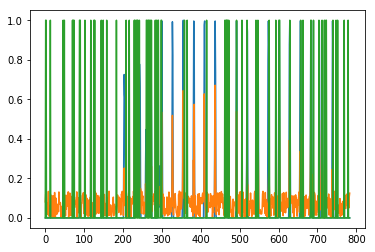

In [92]:
plt.plot(x_test)
plt.plot(x_noise)
print np.mean(x_test), np.mean(x_noise)
plt.plot(np.random.binomial(1,x_noise))

In [64]:
np.where(np.random.multinomial(1, np.ones(28)/28) == 1)[0][0]

23

In [55]:
np.log(1e-16)

-36.841361487904734